In [1]:
"""          ==========     START OF DATA IMPORTS   ==========          """

import subprocess
import sys
import importlib

%reset -f


""" """

import os, re

"""  Attention:  Make sure the libraries are installed  """
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sqlite3
import csv
import category_encoders as ce
from scipy import stats

from sklearn.impute import KNNImputer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


In [2]:

"""          ==========     START OF DATA IMPORTS   ==========          """



global train_dataset, test_dataset, dataset_paths

dataset_paths = {
    "train": "./apartment_for_rent_train.csv",
    "test": "./apartment_for_rent_test.csv"
}

train_dataset = pd.read_csv(dataset_paths["train"], delimiter=",", encoding="utf-8")
test_dataset = pd.read_csv(dataset_paths["test"], delimiter=",", encoding="utf-8")



In [3]:

"""  DATASET - TEST DATA """

# 1. Plan
# -  Rename column names in testing dataset
# -  Initial formatted table (general)
# -  Machine learning readied table (general)

# 2. For Writer's Reference
# -  Top ten ways to clean your data, Microsoft Support
# -  https://support.microsoft.com/en-gb/office/top-ten-ways-to-clean-your-data-2844b620-677c-47a7-ac3e-c2e157d1db19

#    ==========    [  START OF FIRST ROUND CLEEANING  ]    ==========

#  ---- attention: column name in testing dataset are not in its corresponding data


# 1.2    only for testing data

def rename_colname_in_testing_dataset(train_data, test_data):
    list_of_train_colnames = train_data.columns
    test_data.columns = list_of_train_colnames
    return test_data

test_dataset = rename_colname_in_testing_dataset(train_dataset, test_dataset)

#    ==========    [  END OF FIRST ROUND CLEEANING  ]    ==========



In [4]:
"""          ==========     START OF DATA WRAGGLING    ==========          """

#  ---- resue: centralise global declarations

#  0. dataset processing stages
# remarks: formatting on raw data to keep geniue data 
global f_train_data, f_test_data


#  1. column format related

global business_logic_drop_columns, column_types, customised_max_min, crucial_list

#  remarks: the tasks requires to analyse the factor of high rent price, but not user-behavior focused
#           thus, personal data is not useful data, though slightly relevance involved
business_logic_drop_columns = [
    "Reg_id",     #  reg_id is identifier, not meaning to analysis
    "Age",        #  user-behavior focused, though it shows the purchase power (not directly linked)
    "Gender",     #  user-behavior focused, though it shows how different gender's preference and financial power in some geographical area
]

column_types = {
    "string": ["Gender", "Construction_type", "Balcony", "Renovation", "Currency", "Duration", "Furniture"],
    "integer": ["Reg_id", "Age", "Floors_in_the_building", "Number_of_rooms", "Number_of_bathrooms", "Floor", "Children_are_welcome", "Pets_allowed", "Utility_payments"],
    "float": ["Floor_area", "Ceiling_height", "Price"], 
    "boolean": ["New_construction", "Elevator"],
    "list": ["amenities", "appliances", "parking"],
    "datetime": ["Datetime"]
}

crucial_list = {"Price", "Address", "Currency", "Duration"}

customised_max_min = {
    "Ceiling_height": {"min": 2.0, "max": 5.0},
    "Children_are_welcome": {"min": 0, "max": 20},
    "Floor": {"min": 0, "max": 100},
    "Floor_area": {"min": 10, "max": 1000},
    "Floors_in_the_building": {"min": 1, "max": 100},
    "Number_of_bathrooms": {"min": 1, "max": 10},
    "Number_of_rooms": {"min": 1, "max": 10},
    "Utility_payments": {"min": 0, "max": 20}
}


#  2. cell format related

global currency_to_usd, days_per_month, display_decimal_format, general_cleanse_configs, list_towns_armenia, list_street_armenia

currency_to_usd = {
    "AMD": 0.0026,
    "EUR": 1.13,
    "RUB": 0.012,
    "USD": 1.00
}

days_per_month = 30

display_decimal_format = {
    # float, in 2 decimal place
    "Price": "{:,.2f}",
    "Ceiling_height": "{:,.2f}",
    # integer
    "Reg_id": "{:,.0f}",
    "Age": "{:,.0f}",
    "Floors_in_the_building": "{:,.0f}",
    "Floor_area": "{:,.0f}",
    "Number_of_rooms": "{:,.0f}",
    "Number_of_bathrooms": "{:,.0f}",
    "Floor": "{:,.0f}",
    "Children_are_welcome": "{:,.0f}",
    "Pets_allowed": "{:,.0f}",
    "Utility_payments": "{:,.0f}",
}

general_cleanse_configs = {
    "enable_duplicates": {
        "set_active": False,
        "set_inplace": True
    },
    "enable_missing_data": {
        "set_active": False,
        "set_mode": "fill", # ffill / bfill are customised (ffill: for chronological condition; bfill for belated filling condition)
        "set_fillValue": None,  
        "set_inplace": True
    },
    "enable_sorting": {
        "set_active": True,
        "set_column": "Floor_area",
        "set_mode": "ascending",
        "set_inplace": True
    },
    "enable_format_string": {
        "set_active": True,
        "set_case": "lowercase",
        "enable_whitespace": True,
        "enable_specChar": False
    },
    "enable_format_number": {
        "set_active": True,
        "set_max": None,
        "set_min": 0,
        "set_dp": 2    
    },
    "enable_format_datetime": {
        "set_active": True,
        "datetime_option": "date",
        "set_date": "%d/%m/%Y",
        "set_time": "%I:%M %p",
        "set_datetime": "%d/%m/%Y %H:%M:%S"
    }
}

list_towns_armenia = ["Aghavaz", "Alaverdi", "Aparan", "Ararat", "Armavir", "Artashat", "Dilijan", "Gasparyan", "Ganjaser", "Gyumri", "Gyurdzvan", "Goris", "Hovhannand", "Hrazdan", "Ijevan", "Kapan", "Karmir Brd", "Khachadour", "Khndzorsut", "Khor Virap", "Masis","Martuni", "Nor-Avanyan", "Sevan", "Shoghik", "Sisian", "Stepanavan", "Tagh-Aghap", "Talin", "Tashir", "Tateviq", "Tsantsar", "Vanadzor", "Vardenis", "Yerevan"]

dict_town_hy_en = {"Աղավազ": "Aghavaz", "Ալավերդի": "Alaverdi", "Ապարան": "Aparan","Արարատ": "Ararat","Արմավիր": "Armavir","Արտաշատ": "Artashat","Դիլիջան": "Dilijan","Գասպարյան": "Gasparyan","Գանձասար": "Ganjaser","Գյումրի": "Gyumri", "Գյուրդզվան": "Gyurdzvan",  "Գորիս": "Goris", "Հովհաննանդ": "Hovhannand", "Հրազդան": "Hrazdan","Իջևան": "Ijevan","Կապան": "Kapan","Կարմիր բերդ": "Karmir Brd","Խաչադուր": "Khachadour", "Խնձորсут": "Khndzorsut","Խոր Վիրապ": "Khor Virap","Մասիս": "Masis","Մարտունի": "Martuni", "Նոր-Ավանյան": "Nor-Avanyan","Սևան": "Sevan","Շողիկ": "Shoghik","Սիսիան": "Sisian","Սթեփանավան": "Stepanavan","Թաղ-Աղափ": "Tagh-Aghap","Թալին": "Talin","Տաշիր": "Tashir", "Տաթեւիկ": "Tateviq", "Ծանցառ": "Tsantsar", "Վանաձոր": "Vanadzor", "Վարդենիս": "Vardenis","Երևան": "Yerevan"}

list_street_armenia = ["Abelyan Street", "Abovyan Street", "Adana Street", "Admiral Isakov Avenue", "Adonts Street", "Aeracia Street", "Agatangeghos Street", "Agayan Street", "Aghababyan Street", "Aghbyur Serob Street", "Aivazovski Street", "Aksel Bakunts Street", "Alek Manoukyan Street", "Aleksandr Myasnikyan Avenue", "Aleksandr Spendiarian Street", "Aleksandr Tamanyan Street", "Amiryan Street", "Anastas Mikoyan Street", "Antarayin Street", "Ara Sargsyan Street", "Arabkir Street", "Aragats Street", "Aram Cholakyan Street", "Aram Khachatryan Street", "Aram Street", "Araqelyan Street", "Ararat Street", "Araratyan Street", "Arghutyan Street", "Argishti Street", "Armen Tigranyan Street", "Armenak Armenakyan Street", "Armenakyan Street", "Arno Babajanyan Street", "Arshakunyats Avenue", "Artashisyan Street", "Artem Mikoyan Street", "Artsakh Avenue", "Arzumanyan Street", "Ashot Hovhanisyan Street", "Atenk Street", "Atoyan Street", "Avag Petrosyan Street", "Avan Street", "Avanarinj Microdistrict", "Avanesov Street", "Avet Avetisyan Street", "Avetik Isahakyan Street", "Avetis Aharonyan Street", "Aygedzor Street", "Aygektci Street", "Aygestan Street", "Azatamartikneri Street", "Azatutyan Avenue", "Babayan Street", "Badal Muradyan Street", "Baghyan Street", "Bagratunyats Street", "Bagrevand Street", "Barbyus Street", "Bardzraberd Street", "Bashinjaghyan Street", "Beknazaryan Street", "Belyakov Street", "Boryan Street", "Burnazyan Street", "Busabanakan Street", "Byron Street", "Byuzand Street", "Charents Street", "Chaykovski Street", "Chekhov Street", "Daniel Varujan Street", "Davit Anhaght Street", "Davit Bek Street", "Davit Malyan Street", "Davtashen Street", "Deghatan Street", "Derenik Demirchyan Street", "Duryan Street", "Dzorapi Street", "Eghishe Tadevosyan", "Eghishe Tadevosyan Street", "Eghvard Highway", "Erebuni Street", "Erkatgtsi Street", "Estonakan Street", "Ezras Hasratian Street", "Firdusi Street", "Forest Street", "Frik Street", "Frunze Street", "Fuchik Street", "Gagarin Street", "Gai Avenue", "Galshoyan Street", "Garegin Hovsepyan Street", "Garegin Nzhdeh Street", "General Safaryan Street", "Gevorg Chaush Street", "Gevorg Dzhahukyan Street", "Ghapantsian Street", "Ghazar Parpetsi Street", "Ghazaros Aghayan Street", "Glinka Street", "Gogol Street", "Gorgagotsneri Street", "Griboyedov Street", "Grigor Aghababyan Street", "Grigor Artsruni Street", "Grigor Hasratyan Street", "Grigor Lusavorich Street", "Gulakyan Street", "Gusan Sheram", "Gusan Sheram Street", "Gyulbenkyan Street", "Gyulikekhvyan Street", "Gyurjyan Street", "Hakob Hakobyan Street", "Hakob Paronyan Street", "Halabyan Street", "Hanrapetutyan Street", "Hayk Hovsepyan Street", "Hayrik Muradyan Street", "Hin Yerevantsu Street", "Hovhanisyan Street", "Hovhannes Shiraz Street", "Hovhannes Tumanyan Street", "Hovnatan Street", "Hovsep Arghutian Street", "Hovsep Emin Street", "Hrachya Acharyan Street", "Hrachya Kochar Street", "Hrachya Nersisyan Street", "Hrant Shahinyan Street", "Hunan Avetisyan Street", "Isahakyan District", "Israyelyan Street", "Jughayi Street", "Kajaznuni Street", "Kalents Street", "Kamaraki Street", "Karakhanyan Street", "Karapet Ulnetsi Street", "Karen Demirchyan Street", "Karmir Blur Street", "Kasyan Street", "Kentronakan Street", "Khachatur Abovyan Street", "Khaghag Don Street", "Khanjyan Street", "Khnko Apor Street", "Khoren Khachatryan Street", "Khorenatsi Street", "Kievyan Street", "Kocharyan Street", "Komitas Avenue", "Koryun Street", "Kurghinyan Street", "Leningradyan Street", "Leo Street", "Lepsius Street", "Lukashin Street", "Luxemburg Street", "Lvovyan Street", "Magaryan Street", "Malatia Street", "Malkhasyants Street", "Mamikonyants Street", "Manandyan Street", "Mantashyan Street", "Margaryan Street", "Markvart Street", "Marr Street", "Marshal Babajanyan", "Marshal Babajanyan Street", "Marshal Baghramyan Avenue", "Marshal Khudyakov Street", "Martiros Saryan Street", "Mayisi Street", "Mazmanyan Street", "Meliq Meliqyan Street", "Melkumov Srteet", "Mesrop Mashtots Avenue", "Mher Mkrtchyan Street", "Mikayel Nalbandyan Street", "Mikayelyan Street", "Minas Avetisyan Street", "Minsk Street", "Mkhitar Heratsi Street", "Moldovakan Street", "Moskovyan Street", "Movses Khorenatsi Street", "Muratsan Street", "Myasnikyan Avenue", "Nairi Zaryan Street", "Nalbandyan Street", "Nansen Street", "Nardos Street", "Narekatsi District", "Nazaret Surenyan Street", "Nelson Stepanyan Street", "Nerkin Charbakh Street", "Nerqin Shengavit Street", "Nikoghayos Adonts Street", "Nikoghayos Tigranyan Street", "Nikol Duman Street", "Nizami Street", "Nor Aresh Street", "Noragavit Street", "Noragyugh Street", "Noraresh Street", "Norashen District", "Nork Street", "Northern Avenue", "Nubarashen Street", "Ohanov Street", "Orbeli Brothers Street", "Ostrovski Street", "Paronyan Street", "Parpetsi Street", "Paruyr Sevak Street", "Pavstos Buzand Street", "Petros Adamyan Street", "Petros Duryan Street", "Pirumyanner Street", "Proshyan Street", "Pushkin Street", "Qanaqer Street", "Qeri Street",  "Qochinyan Street", "Quchak Street", "Rafael Lemkin Street", "Raffi Street", "Rapael Lemkin Street", "Raynis Street", "Republic Square", "Riga Street", "Rostom Street", "Rostovyan Street", "Rubiniants Street", "Sakharov Street", "Samvel Safaryan Street", "Sari Tagh Street", "Sarkis Kasyan Street", "Sarmen Street", "Saryan Street", "Sasna Tsrer Street", "Sasuntsi Davit Street", "Sayat Nova Avenue", "Sayatnova Avenue", "Sebastia Street", "Sepuh Street", "Sero Khanzadyan Street", "Sevan Street", "Sevkaretsi Sako Street", "Shahsuvaryan Street", "Shahumyan Street", "Shara Talyan Street", "Sharuri Street", "Shevchenko Street", "Shinararner Street", "Shirak Street", "Shirvanzade Street", "Shopron Street", "Shovroyan Street", "Shrjanain Street", "Silva Kaputikyan Street", "Simon Vratsyan Street", "Sisakyan Street", "Smbat Zoravar Street", "Sose Street", "Stepan Zoryan Street", "Sundukyan Street", "Surb Grigor Lusavorich Street", "Svachyan Street", "Tairov Street", "Tamanyan Street", "Taronts Street", "Tbilisian Highway", "Terlemezyan Street", "Teryan Street", "Tevosyan Street", "Tichina Street", "Tigran Mets Avenue", "Tigran Petrosyan", "Tigran Petrosyan Street", "Titogradian Street", "Titogradyan", "Totovents Street", "Tpagrichner Street", "Tsarav Aghbyur Street", "Tsaturyan Street", "Tserents Street", "Tsitsernakaberd Highway", "Tumanyan Street", "Vagharsh Vagharshyan Street", "Vahagn Davtian Street", "Vahagni Street", "Vahan Teryan Street", "Vahram Papazyan Street", "Vardan Achemyan Street", "Vardanants Street", "Varlam Avanesov Street", "Vazgen Sargsyan Street", "Verin Antarayin Street", "Verin Shengavit Street", "Viktor Hambardzumyan Street", "Vilnyus Street", "Voskanyan Street", "Vratsakan Street", "Vrtanes Papazyan Street", "Vshtuni Street", "Yeghbayrutyan Street", "Yeghishe Charents Street", "Yekmalyan Street", "Yervand Kochar Street", "Yervand Otyan Street", "Yeznik Koghbatsi Street", "Yerznkian Street", "Zakaria Sarkavag Street", "Zaqyan Street", "Zarobyan Street", "Zavaryan Street", "Zoravar Andranik Street"]

dict_street_hy_en = {"Աբելյան": "Abelyan Street","Աբովյան": "Abovyan Street","Ադանա": "Adana Street","Ադմիրալ Իսակովի": " Admiral Isakov  ","Ադոնց": " Adonts Street ","Աերացիա": "Aeracia Street","Ագատանգեղոս": "Agatangeghos Street","Ագայան": "Agayan Street","Աղաբաբյան ": "Aghababyan Street","Աղբյուր Սերոբ ": "Aghbyur Serob Street","Айвазовски ": "Aivazovski Street","Աքսել Բակունց ": "Aksel Bakunts Street","Ալեք Մանուկյան ": "Alek Manoukyan Street","Ալեքսանդր Մյասնիկյան ": "Aleksandr Myasnikyan ", "Ալեքսանդր Սպենդիարյան ": "Aleksandr Spendiarian Street","Ալեքսանդր Թամանյան ": "Aleksandr Tamanyan Street", "Ամիրյան ": "Amiryan Street","Անաստաս Միկոյան ": "Anastas Mikoyan Street","Անտառային ": "Antarayin Street","Արա Սարգսյան ": "Ara Sargsyan Street","Արաբկիր ": "Arabkir Street","Արագած ": "Aragats Street","Արամ Չոլաքյան ": "Aram Cholakyan Street", "Արամ Խաչատրյան ": "Aram Khachatryan Street","Արամ ": "Aram Street","Արաքելյան ": "Araqelyan Street","Արարատ ": "Ararat Street","Արարատյան ": "Araratyan Street", "Արգության ": "Arghutyan Street", "Արգիշտի ": "Argishti Street", "Արմեն Տիգրանյան ": "Armen Tigranyan Street","Արմենակ Արմենակյան ": "Armenak Armenakyan Street","Արմենակյան ": "Armenakyan Street","Արնո Բաբաջանյան ": "Arno Babajanyan Street","Արշակունյաց ": "Arshakunyats ","Արտաշիսյան ": "Artashisyan Street","Արթեմ Միկոյան ": "Artem Mikoyan Street", "Արցախ ": "Artsakh ","Արզումանյան ": "Arzumanyan Street","Աշոտ Հովհանիսյան ": "Ashot Hovhanisyan Street","Աթենկ ": "Atenk Street","Աթոյան ": "Atoyan Street", "Ավագ Պետրոսյան ": "Avag Petrosyan Street", "Ավան ": "Avan Street","Ավանարինջ ": "Avanarinj Microdistrict","Ավանեսով ": "Avanesov Street","Ավետ Ավետիսյան ": "Avet Avetisyan Street",  "Ավետիկ Իսահակյան ": "Avetik Isahakyan Street","Ավետիս Ահարոնյան ": "Avetis Aharonyan Street",  "Այգեզոր ": "Aygedzor Street","Այգեկտցի ": "Aygektci Street",  "Այգեստան ": "Aygestan Street", "Ազատամարտիկների ": "Azatamartikneri Street","Ազատության ": "Azatutyan ","Բաբայան ": "Babayan Street","Բադալ Մուրադյան ": "Badal Muradyan Street","Բաղյան ": "Baghyan Street","Բագրատունյաց ": "Bagratunyats Street","Բագրևանդ ": "Bagrevand Street","Բարբյուս ": "Barbyus Street","Բարձրաբերեդ ": "Bardzraberd Street","Բաշինջաղյան ": "Bashinjaghyan Street","Բեկնազարյան ": "Beknazaryan Street","Բելյակով ": "Belyakov Street","Բորյան ": "Boryan Street","Բուրզանյան ": "Burnazyan Street","Բուսաբանական ": "Busabanakan Street","Բայրոն ": "Byron Street","Բյուզանդ ": "Byuzand Street","Չարենց ": "Charents Street","Չայկովսկի ": "Chaykovski Street","Չեխով ": "Chekhov Street","Դանիել Վարուժան ": "Daniel Varujan Street","Դավիթ Ախաղթ ": "Davit Anhaght Street","Դավիթ Բեկ ": "Davit Bek Street","Դավիթ Մալյան ": "Davit Malyan Street","Դավթաշեն ": "Davtashen Street","Դեղատան ": "Deghatan Street","Դերենիկ Դեմիրճյան ": "Derenik Demirchyan Street","Դուրյան ": "Duryan Street","Ձորափի ": "Dzorapi Street","Եղիշե Թադևոսյան": "Eghishe Tadevosyan","Եղիշե Թադևոսյան ": "Eghishe Tadevosyan Street","Եղվարդ մայրուղի": "Eghvard Highway","Երեբունի ": "Erebuni Street","Էրքատգցի ": "Erkatgtsi Street","Էստոնական ": "Estonakan Street","Էզրաս Հասրատյան ": "Ezras Hasratian Street","Ֆիրդուսի ": "Firdusi Street","Անտառային ": "Forest Street","Ֆրիկ ": "Frik Street","Ֆրունզե ": "Frunze Street","Ֆուչիկ ": "Fuchik Street","Գագարին ": "Gagarin Street","Գայի ": "Gai ","Գալշոյան ": "Galshoyan Street","Գարեգին Հովսեփյան ": "Garegin Hovsepyan Street","Գարեգին Նժդեհ ": "Garegin Nzhdeh Street","Զինվորական Սարֆարյան ": "General Safaryan Street","Գևորգ Ճաուշ ": "Gevorg Chaush Street", "Գևորգ Ջահուկյան ": "Gevorg Dzhahukyan Street","Գապանցյան ": "Ghapantsian Street","Ղազար Պարպեցի ": "Ghazar Parpetsi Street","Ղազարոս Աղայան ": "Ghazaros Aghayan Street","Գլինկա ": "Glinka Street","Գոգոլ ": "Gogol Street","Գորգագծներ ": "Gorgagotsneri Street","Գրիբոյեդով ": "Griboyedov Street","Գրիգոր Աղաբաբյան ": "Grigor Aghababyan Street","Գրիգոր Արսրունի ": "Grigor Artsruni Street","Գրիգոր Հասրաթյան ": "Grigor Hasratyan Street","Գրիգոր Լուսավորիչ ": "Grigor Lusavorich Street","Գուլակյան ": "Gulakyan Street","Գուսան Շերամ": "Gusan Sheram","Գուսան Շերամ ": "Gusan Sheram Street","Գյուլբենկյան ": "Gyulbenkyan Street","Գյուլիկեխվյան ": "Gyulikekhvyan Street","Գյուրջյան ": "Gyurjyan Street",   "Հակոբ Հակոբյան ": "Hakob Hakobyan Street","Հակոբ Պարոնյան ": "Hakob Paronyan Street","Հալաբյան ": "Halabyan Street","Հանրապետության ": "Hanrapetutyan Street","Հայկ Հովսեփյան ": "Hayk Hovsepyan Street", "Հայրիկ Մուրադյան ": "Hayrik Muradyan Street","Հին Երեւանցու ": "Hin Yerevantsu Street","Հովհանիսյան ": "Hovhanisyan Street","Հովհաննես Շիրազ ": "Hovhannes Shiraz Street", "Հովհաննես Թումանյան ": "Hovhannes Tumanyan Street", "Հովնաթան ": "Hovnatan Street","Հովսեփ Արգուտյան ": "Hovsep Arghutian Street","Հովսեփ Էմին ": "Hovsep Emin Street","Հրաչյա Աճառյան ": "Hrachya Acharyan Street","Հրաչյա Քոչար ": "Hrachya Kochar Street","Հրաչյա Ներսիսյան ": "Hrachya Nersisyan Street","Հրանդ Շահինյան ": "Hrant Shahinyan Street","Հունան Ավետիսյան ": "Hunan Avetisyan Street","Իսահակյան ": "Isahakyan District","Իսրայելյան ": "Israyelyan Street","Ջուղայի ": "Jughayi Street","Քաջազնունի ": "Kajaznuni Street","Կալենց ": "Kalents Street","Կամարակի ": "Kamaraki Street","Քարախանյան ": "Karakhanyan Street","Քարապետ Ուլնեցի ": "Karapet Ulnetsi Street",   "Քարեն Դեմիրճյան ": "Karen Demirchyan Street","Կարմիր Բլուր ": "Karmir Blur Street","Կասյան ": "Kasyan Street","Կենտրոնական ": "Kentronakan Street","Խաչատուր Աբովյան ": "Khachatur Abovyan Street","Խաղաղ Դոն ": "Khaghag Don Street","Խանջյան ": "Khanjyan Street","Խնկո Ապոր ": "Khnko Apor Street","Խորեն Խաչատրյան ": "Khoren Khachatryan Street","Խորենացի ": "Khorenatsi Street","Կիևյան ": "Kievyan Street","Կոչարյան ": "Kocharyan Street","Կոմիտաս ": "Komitas ","Կորյուն ": "Koryun Street","Քուրգինյան ": "Kurghinyan Street","Լենինգրադյան ": "Leningradyan Street","Լեո ": "Leo Street","Լեպսիուս ": "Lepsius Street","Լուկաշին ": "Lukashin Street","Լյուքսեմբուրգ ": "Luxemburg Street","Լվովյան ": "Lvovyan Street","Մարգարյան ": "Magaryan Street","Մալաթիա ": "Malatia Street","Մալխասյանց ": "Malkhasyants Street","Մամիկոնյանց ": "Mamikonyants Street","Մանանդյան ": "Manandyan Street","Մանտաշյան ": "Mantashyan Street","Մարգարյան ": "Margaryan Street","Մարկվարտ ": "Markvart Street","Մար ": "Marr Street","Մարշալ Բաբաջանյան": "Marshal Babajanyan","Մարշալ Բաբաջանյան ": "Marshal Babajanyan Street","Մարշալ Բաղրամյան ": "Marshal Baghramyan ","Մարշալ Խուդյակով ": "Marshal Khudyakov Street",    "Մարտիրոս Սարյան ": "Martiros Saryan Street", "Մայիսի ": "Mayisi Street","Մազմանյան ": "Mazmanyan Street","Մելիք Մելիքյան ": "Meliq Meliqyan Street","Մելքումով ": "Melkumov Srteet","Մեսրոպ Մաշտոց ": "Mesrop Mashtots ","Մետաքսի ": "Metaksi Street","Մհեր Մկրտչյան ": "Mher Mkrtchyan Street","Միկոյան ": "Mikoyan Street","Մինասյան ": "Minasyan Street","Միրաքյան ": "Mirakyan Street","Միսակ Մկրտչյան ": "Misak Mkrtchyan Street","Մուսայելյան ": "Musayelyan Street","Նալբանդյան ": "Nalbandyan Street","Նազարբեկյան ": "Nazaryan Street","Նաիրի Զարյան ": "Nairi Zaryan Street","Նալբանդյան ": "Nalbandyan Street","Նարեկացի ": "Narekatsi Street","Նարեկացիի ": "Narekatsi ","Ներսիսյան ": "Nersisyan Street","Նուբարաշեն": "Nubarashen","Նշանակալի ": "Nshanakali Street","Նորաշեն": "Norashen","Նորավան": "Noravan","Նորայրի ": "Norayri Street","Նորայրի ": "Norayri ", "Նորայրի թաղամաս": "Norayri District","Նորաշեն թաղամաս": "Norashen District","Նորագետ": "Noraget","Նորավան ": "Noravan Street","Նորաշեն ": "Norashen Street","Նոյյան ծովատառ": "Noyan Tsovatary","Նոյյան ": "Noyan Street","Նորավան ": "Noravan Street","Նորավան շեն": "Noravan Settlement","Նորայրի շեն": "Norayri Settlement","Նոյյան շեն": "Noyan Settlement","Նորավան թաղամաս": "Noravan District","Նոյյան թաղամաս": "Noyan District", "Նորաշեն թաղամաս": "Norashen District","Նորաշեն շեն": "Norashen Settlement","Նորավան շեն": "Noravan Settlement","Նորայրի շեն": "Norayri Settlement", "Նոյյան շեն": "Noyan Settlement","Նորաշեն ": "Norashen Street","Նորավան ": "Noravan Street","Նորայրի ": "Norayri Street","Նոյյան ": "Noyan Street","Նորաշեն ": "Norashen ","Նորավան ": "Noravan ","Նորայրի ": "Norayri ","Նոյյան ": "Noyan ","Օրբելի եղբայրների ": "Orbeli Brothers Street","Օստրովսկու ": "Ostrovski Street","Փարոնյան ": "Paronyan Street","Փարփեցի ": "Parpetsi Street","Փարույր Սևակ ": "Paruyr Sevak Street","Պավստոս Բուզանդ ": "Pavstos Buzand Street","Պետրոս Ադամյան ": "Petros Adamyan Street","Պետրոս Դուռյան ": "Petros Duryan Street","Պիրումյաններ ": "Pirumyanner Street","Պրոշյան ": "Proshyan Street","Պուշկինի ": "Pushkin Street","Քանաքեռ ": "Qanaqer Street","Քերի ": "Qeri Street","Քոչինյան ": "Qochinyan Street","Քուչակ ": "Quchak Street","Ռաֆայել Լեմկին ": "Rafael Lemkin Street","Ռաֆֆի ": "Raffi Street","Ռաֆայել Լեմկին ": "Rapael Lemkin Street", "Ռեյնիս ": "Raynis Street","Հանրապետության հրապարակ": "Republic Square","Ռիգա ": "Riga Street","Ռոստոմ ": "Rostom Street","Ռոստովյան ": "Rostovyan Street","Ռուբինյանց ": "Rubiniants Street","Սախարով ": "Sakharov Street","Սամվել Սաֆարյան ": "Samvel Safaryan Street","Սարի թաղ ": "Sari Tagh Street","Սարգիս Կասյան ": "Sarkis Kasyan Street","Սարմեն ": "Sarmen Street","Սարյան ": "Saryan Street","Սասնա ծռեր ": "Sasna Tsrer Street","Սասունցի Դավիթ ": "Sasuntsi Davit Street","Սայաթ Նովա ": "Sayat Nova ","Սայաթնովա ": "Sayatnova ","Սեբաստիա ": "Sebastia Street","Սեպուհ ": "Sepuh Street","Սերո Խանզադյան ": "Sero Khanzadyan Street","Սևան ": "Sevan Street","Սևքարեցին Սաքո ": "Sevkaretsi Sako Street","Շահսուվարյան ": "Shahsuvaryan Street","Շահումյան ": "Shahumyan Street","Շարա Թալյան ": "Shara Talyan Street","Շարուրի ": "Sharuri Street","Շևչենկո ": "Shevchenko Street", "Շինարներ ": "Shinararner Street","Շիրակ ": "Shirak Street","Շիրզանզադե ": "Shirvanzade Street","Շոպրոն ": "Shopron Street","Շովրոյան ": "Shovroyan Street","Շրժանյան ": "Shrjanain Street","Սիլվա Կապուտիկյան ": "Silva Kaputikyan Street","Սիմոն Վրացյան ": "Simon Vratsyan Street","Սիսակյան ": "Sisakyan Street","Սմբատ Զորավար ": "Smbat Zoravar Street","Սոսե ": "Sose Street","Ստեփան Զորյան ": "Stepan Zoryan Street","Սունդուկյան ": "Sundukyan Street","Սուրբ Գրիգոր Լուսավորիչ ": "Surb Grigor Lusavorich Street","Սվաճյան ": "Svachyan Street","Թաիրով ": "Tairov Street","Թամանյան ": "Tamanyan Street","Թարոնց ": "Taronts Street","Թբիլիսյան ": "Tbilisian Highway","Թերլեմեզյան ": "Terlemezyan Street","Թերյան ": "Teryan Street","Թևոսյան ": "Tevosyan Street","Տիչինա ": "Tichina Street","Տիգրան Մեծ ": "Tigran Mets ","Տիգրան Պետրոսյան ": "Tigran Petrosyan Street","Տիտոգրադյան ": "Titogradyan Street","Տոտովենց ": "Totovents Street","Թաղրիչներ ": "Tpagrichner Street","Ծարավ Աղբյուր ": "Tsarav Aghbyur Street","Ծատուրյան ": "Tsaturyan Street","Ծերենց ": "Tserents Street","Ծիծեռնակաբերդ ": "Tsitsernakaberd Highway","Թումանյան ": "Tumanyan Street","Վաղարշ Վաղարշյան ": "Vagharsh Vagharshyan Street","Վահագն Դավթյան ": "Vahagn Davtian Street","Վահագնի ": "Vahagni Street","Վահան Տերյան ": "Vahan Teryan Street","Վահրամ Պապազյան ": "Vahram Papazyan Street","Վարդան Աճեմյան ": "Vardan Achemyan Street","Վարդանանց ": "Vardanants Street","Վարլամ Ավանեսով ": "Varlam Avanesov Street","Վազգեն Սարգսյան ": "Vazgen Sargsyan Street","Վերին Անտառային ": "Verin Antarayin Street","Վերին Շենգավիթ ": "Verin Shengavit Street","Վիկտոր Համբարձումյան ": "Viktor Hambardzumyan Street","Վիլնյուս ": "Vilnyus Street","Վոսկանյան ": "Voskanyan Street","Վրացական ": "Vratsakan Street","Վրթանես Պապազյան ": "Vrtanes Papazyan Street","Ուշտունի ": "Vshtuni Street","Եղբայրություն ": "Yeghbayrutyan Street","Եղիշե Չարենց ": "Yeghishe Charents Street","Եկմալյան ": "Yekmalyan Street","Երվանդ Քոչար ": "Yervand Kochar Street","Երվանդ Օտյան ": "Yervand Otyan Street","Եզնիկ Կողբացի ": "Yeznik Koghbatsi Street","Երզնկյան ": "Yerznkian Street","Զաքարյա Սարգսյան ": "Zakaria Sarkavag Street",  "Զաքյան ": "Zaqyan Street","Զարոբյան ": "Zarobyan Street","Զավարյան ": "Zavaryan Street","Զորավար Անդրանիկ ": "Zoravar Andranik Street"}


In [5]:

"""  DATA CLEANING: INITIAL CLEANING FUNCTIONS (1) """

#  ----  reuse functions


#  1. centralise error msgs control

def errorMessaging(section, function, exception):
    print(f'[Error] Section "{section.lower()}" failed. Function "{function.lower()}" is not working.\n- Reference: {str(exception).lower()}')

def exceptCases(section, function, msgs):
    print(f'[Exception] Section "{section.lower()}" is excepted. Function "{function.lower()}" skipped the this execution.\n- Reference: {msgs.lower()}')


# 2. column managemenet functions

def get_valid_column(dataset, input_column):
    for column in dataset.columns:
        if column.lower() == input_column.lower():
            return column
    return None

def create_column(dataset, col_name):
    if col_name in dataset.columns:
        exceptCases("centralised panel", "create_column", "the given column name is existed in the dataset. this functions will not be operated.")
    dataset[col_name] = None
    return dataset

def rename_column(dataset, prev, new):     
    indicator = get_valid_column(dataset, prev)
    dataset.rename(columns={indicator: new}, inplace=True)  

def drop_column(dataset, column):
    if column in dataset.columns:
        dataset = dataset.drop(columns=[column])
    return dataset

#    ==========  [  END OF REUSED FUNC  ]    ==========



In [6]:

"""  DATA CLEANING: INITIAL CLEANING FUNCTIONS (2) """


#  1.1. sorting

def handle_sorting(dataset, set_mode, set_column):
    #  error handling for invalid sorting mode
    if set_mode.lower() not in {"ascending", "descending"}:
        exceptCases("general data wraggling", "sorting", "Invalid sorting mode. Only 'ascending' or 'descending' are allowed.")
        return

    ascending_mode = set_mode.lower() == "ascending"
    
    # If no column is specified, sort across all columns
    if set_column is None:
        exceptCases("general data wraggling", "sorting", "No column specified for sorting. Sorting across all columns.")
        dataset.sort_values(by=dataset.columns.tolist(), ascending=ascending_mode)
    else:
        # Check if the specified column exists in the dataset
        if set_column not in dataset.columns:
            exceptCases("general data wraggling", "sorting", f"Column \"{set_column}\" not found in the dataset.")
            return
        
        # Perform sorting by the specified column
        dataset.sort_values(by=set_column, ascending=ascending_mode, inplace=True)
    

#  1.2. duplicates

def handle_duplicates(dataset):
    dataset = dataset.drop_duplicates()
    return dataset


#  1.3. empty types

def handle_empty_cells(dataset):
    dataset = dataset.replace(["nan", "NaN", "none", "None", "", None], None)
    dataset = dataset.replace(["nan", "NaN", "none", "None", "", None], None)
    return dataset


def drop_null_in_crucial_column(dataset, crucial_list):
    valid_list = []
    for column in crucial_list:
        if column in dataset.columns:
            valid_list.append(column)
        else:
            exceptCases("data wraggling", "drop_null_in_crucial_column", f"target column is not found. the column {column} will be skipped.")
    for column in dataset.columns:
        to_be_updated = []
        for value in dataset[column]:
            if isinstance(value, str) and value.strip() == "Not Specified":
                to_be_updated.append(None)
            else:
                to_be_updated.append(value)
        dataset[column] = to_be_updated
    return dataset

#  1.4  remove extremely poor data rows (3 or more Not Specified)
def remove_extreme_poor_row(dataset):
    temp = []
    for index, row in dataset.iterrows():
        count = 0
        for cell_value in row:
            if cell_value == "Not Specified":
                count = count + 1
        if count <= 3:
            temp.append(index)
    return dataset.loc[temp]

# translation
def earlier_stage_translation(dataset, address_column):
    for index in dataset.index:
        cell_value = dataset.loc[index, address_column]
        #  supposedly they are string
        if not isinstance(cell_value, str):
            continue
        #  translate by dictionery
        for town_hy, town_en in dict_town_hy_en.items():
            cell_value = cell_value.replace(town_hy, town_en)
        for str_hy, str_en in dict_street_hy_en.items():
            cell_value = cell_value.replace(str_hy, str_en)
        dataset.loc[index, address_column] = cell_value
    return dataset
            
                
#    ==========  [  END OF SUPPORTING FUNCTION:  INITIALISE]    ==========
    


In [ ]:

"""  DATA CLEANING: SUPPORTING CLEANING FUNCTIONS """


#  2.1. types

#  2.1.1. string

def convert_string_case_format(input_string, selected_case):
    selected_case = selected_case.lower()
    if selected_case in ["lower", "lowercase"]:
        return input_string.lower()
    elif selected_case in ["upper", "uppercase"]:
        return input_string.upper()
    elif selected_case == "title":
        return input_string.title()
    elif selected_case in ["capitalize", "capitalise"]:
        return input_string.capitalize()
    else:
        return input_string

def remove_string_address_specchar_num(input_string):
    input_string = re.sub(r"[^A-Za-z\s,]", "", input_string)
    return input_string
    
def remove_string_whitespace(input_string):
    #  prevent users use underline for whitespace
    input_string = input_string.replace("_", " ")
    #  remove space at the beginning and the end
    input_string = input_string.strip()
    #  remove space before comma and fullstop
    input_string = re.sub(r"\s+(?=[,._])", "", input_string)
    #  remove if only comma or fullstop left
    if input_string == "." or input_string == "," or input_string == "":
        return None

    return input_string

def format_string_columns(dataset, column):
    for index in dataset.index:
        cell_string = dataset.loc[index, column]
        if pd.isna(cell_string) or pd.isnull(cell_string) or cell_string is None:
            cell_string = "Not Specified"
        else:
            cell_string = str(cell_string)
            cell_string = cell_string.replace("_", " ")
            cell_string = remove_string_address_specchar_num(cell_string)
            cell_string = remove_string_whitespace(cell_string)
            if pd.notna(cell_string) and cell_string.strip() != "":
                cell_string = convert_string_case_format(cell_string, "title")
            else:
                cell_string = "Not Specified"
            dataset.loc[index, column] = cell_string    
    return dataset


#  2.1.2. integers

def handle_max_and_min(value, min=None, max=None):
    #  remarks: convert to none
    if value is None or (isinstance(value, float) and np.isnan(value)):
        return None
    if value is np.nan:
        return None
    #  check with min and max values, invalid will be NaN and will be handled before ML processing
    if min is not None and value < min:
        return None
    if max is not None and value > max:
        return None
    return int(value)


def remove_string_keep_num(input_string):
    return re.sub(r'[^0-9-]', '', input_string)


def validate_integer(value, min=None, max=None):  
    if isinstance(value, str):
        value = remove_string_keep_num(value.strip())
    value = int(value)
    return handle_max_and_min(value, min, max)


def format_integer_columns(dataset, column):
    def reused_float_int_update(cell_integer):
        if isinstance(cell_integer, float):
            if cell_integer.is_integer():
                return int(cell_integer)
            else:
                return None
        if isinstance(cell_integer, int):
            return int(cell_integer)
        return None
            
    for index in dataset.index:
        cell_integer = dataset.at[index, column]
        #  remarks: consider string input e.g., "2.14", "1.43", "2", "1"
        if isinstance(cell_integer, str):
            cell_integer = cell_integer.strip().lower() 
            dataset.at[index, column] = reused_float_int_update(cell_integer)
        #  remarks: convert to integer, use default rounding with int() function
        dataset.at[index, column] =reused_float_int_update(cell_integer)
    return dataset

def remove_string_keep_num(input_string):
    return re.sub(r'[^0-9-]', '', input_string)

def validate_integer(value, min=None, max=None):  
    if isinstance(value, str):
        value = remove_string_keep_num(value.strip())
    value = int(value)
    return handle_max_and_min(value, min, max)


def format_integer_columns(dataset, column):
    def reused_float_int_update(cell_integer):
        if isinstance(cell_integer, float):
            if cell_integer.is_integer():
                return int(cell_integer)
            else:
                return None
        if isinstance(cell_integer, int):
            return int(cell_integer)
        return None
    #  remarks: validate column name
    if get_valid_column(dataset, column) is None:
        return exceptCases("data wraggling", "format_integer_columns", "input column is not found. the function will be skipped.")
    #  execution
    for index in dataset.index:
        cell_integer = dataset.at[index, column]
        #  remarks: consider string input e.g., "2.14", "1.43", "2", "1"
        if isinstance(cell_integer, str):
            cell_integer = cell_integer.strip()
            dataset.at[index, column] = reused_float_int_update(cell_integer)
        #  remarks: convert to integer, use default rounding with int() function
        dataset.at[index, column] =reused_float_int_update(cell_integer)
    return dataset


def format_numbers_range(dataset, customised_max_min):
    #  better to loop the config object, otherwise will be a bug for numbers column which is not in list
    for column, limits in customised_max_min.items():
        #  make sure currently on list
        if column in dataset.columns:
        #  remarks: avoid warning of NaN
            for index in dataset.index:
                curr = dataset.at[index, column]
                updates = handle_max_and_min(curr, limits.get("min"), limits.get("max"))
                dataset.at[index, column] = updates
    return dataset



#  2.1.3. floats
                
def handle_float_round_decimal(input_number, decimal=2):
    if pd.isna(input_number):
        return None
    output = float(input_number)
    return round(output, decimal)


def handle_float_round_decimal(input_number, decimal=2):
    if pd.isna(input_number):
        return None
    output = float(input_number)
    return round(output, decimal)


def format_float_columns(dataset, column, decimal):
    dataset[column] = dataset[column].fillna(np.nan)
    #  execution
    for index in dataset.index:
        cell_float = dataset.at[index, column]  
        #  remarks: convert empty or null into None
        if pd.isna(cell_float):
            dataset.at[index, column] = None
            continue
        #  remarks: consider string input e.g., "2.00", "3.5"
        if isinstance(cell_float, str):
            cell_float = float(cell_float.strip())
            continue 
        #  remarks: round in selected decimal place, only numbers
        if isinstance(cell_float, (int, float)):
            cell_float = handle_float_round_decimal(cell_float, decimal)
            dataset.at[index, column] = cell_float
        else:
            dataset.at[index, column] = None
    return dataset


def limit_numeric_range(dataset, columns_list, config):
    for column in columns_list:
        valid = get_valid_column(dataset, column)
        #  remarks: get criteria
        if valid and valid in config:
            minimum = config[valid]["min"]
            maximum = config[valid]["max"]
            #  remarks: maximum must be larger than minimum
            if maximum < minimum:
                dataset[valid] = None
                continue 
            #  remarks: loop to read cells
            for index in range(len(dataset)):
                value = dataset.at[index, valid]
                # remarks: change to nan if exceed range
                if isinstance(value, (int, float)):
                    if value < minimum or value > maximum:
                        dataset.at[index, valid] = None
                else:
                    dataset.at[index, valid] = None
    return dataset


# 2.1.4   boolean, ML model only accept 0s and 1s

def format_boolean_columns(dataset, column):
    #  declaration
    temp = []
    for index in dataset.index:
        cell_value = str(dataset.loc[index, column])
        if (cell_value.lower() == "1" or cell_value.lower() == "1.0" or cell_value.lower() == "true" or cell_value.lower() == "yes"):
            temp.append("Yes")
        elif (cell_value.lower() == "0" or cell_value.lower() == "0.0" or cell_value.lower() == "false" or cell_value.lower() == "no"):
            temp.append("No")
        else:
            temp.append("Not Specified")        
    #  update
    dataset[column] = temp
    #  remarks: because of warning, add .astype
    return dataset


# 2.1.5   datetime

def handle_timestap_input(input_timestamp):
    # declaration
    timestamp = None
    # empty checks
    if pd.isna(input_timestamp):
        return None
    # update
    else:
        if isinstance(input_timestamp, (int, float)):
            timestamp = pd.to_datetime(input_timestamp, unit="ns")
        elif isinstance(input_timestamp, pd.Timestamp):
            timestamp = input_timestamp.timestamp()
        elif isinstance(input_timestamp, str):
            timestamp = pd.to_datetime(input_timestamp, dayfirst=True)
            if pd.isna(timestamp):
                return None
            timestamp = timestamp.timestamp()
    return timestamp


def expand_datetime_column(dataset, timestamp_column):
    dataset[timestamp_column] = pd.to_datetime(dataset[timestamp_column], errors="coerce")
    
    return dataset

    
#  remarks: scikit_learn dun accept datetime, but timestamp
def format_datetime_columns(dataset, column):
    datetime_max = pd.to_datetime("today").normalize().timestamp()
    datetime_min = pd.to_datetime("1900-01-01").timestamp()
    list_year = []
    list_month = []
    list_day = []
    dataset[column] = pd.to_datetime(dataset[column], format="%d/%m/%Y", errors="coerce")
    
    for index in range(len(dataset)):
        cell_value = dataset.loc[index, column]
        datetime_curr = handle_timestap_input(cell_value)
        
        if datetime_curr  is not None:
            if datetime_curr  > datetime_max or datetime_curr  < datetime_min:
                list_year.append(None)
                list_month.append(None)
                list_day.append(None)
            else:
                list_year.append(str(cell_value.year))
                list_month.append(str(cell_value.month))
                list_day.append(str(cell_value.day))
        else:
                list_year.append(None)
                list_month.append(None)
                list_day.append(None)
    dataset["Date (Year)"] = pd.Series(list_year).astype("string")
    dataset["Date (Month)"] = pd.Series(list_month).astype("string")
    dataset["Date (Day)"] = pd.Series(list_day).astype("string")
    return dataset


#  2.1.6   list

def create_list_status(dataset, column):
    new_name = f"{column} (status)"
    temp = []
    for index in dataset.index:
        cell_value = str(dataset.loc[index, column]).strip()
        # set up criteria
        if pd.isna(cell_value) or str(cell_value).strip().lower() in ["", "none"]:
            temp.append("Not Specified")
        else:
            temp.append("Yes")
    dataset = create_column(dataset, new_name)
    dataset[new_name] = temp
    return dataset


#  optional, convert to list, can be further encoding or hashing
# from sklearn.preprocessing import MultiLabelBinarizer

# def format_list_column(dataset, column):
#     #  remarks: warning code provided, no need to change
#     new_name = f"{column} (hashset)"
#     dataset[column] = dataset[column].astype(object)  
#     for index in dataset.index:
#         cell = str(dataset.at[index, column]).strip()
#         if cell.lower() in ["", "none", "nan"]:
#             dataset.at[index, column] = []
#             continue
#         items = cell.split(",")
#         formatted_list = []
#         for item in items:
#             item = item.strip().replace("_", " ")
#             item = remove_string_address_specchar_num(item)
#             item = remove_string_whitespace(item)
#             if item:
#                 item = convert_string_case_format(item, "title")
#                 formatted_list.append(item)
#         print(formatted_list)
#         dataset.at[index, column] = formatted_list
#     [TODO] encoding for csv storage
#     mlb = MultiLabelBinarizer()
#     encoded_df = pd.DataFrame(
#         mlb.fit_transform(dataset[column]),
#         columns=[f"{new_name}: {cls}" for cls in mlb.classes_],
#         index=dataset.index
#     )
#     dataset = pd.concat([dataset.drop(columns=[column]), encoded_df], axis=1)
    
#     return dataset




In [8]:
#    ==========  [  START OF SUPPORTING FUNCTION:  SPEC COLUMN ]    ==========

#  ---- task: currency

def format_currency_style(dataset, column):
    #  remarks: trace by column index
    column_index = dataset.columns.get_loc(column)
    #  execution
    #  remarks: initially, invalid cells fill with None, will drop the row before input to ML model
    for index in range(len(dataset)):
        cell_string = str(dataset.iloc[index, column_index])
        cell_string_upper = convert_string_case_format(cell_string, "upper")
        if cell_string_upper not in currency_to_usd:
            dataset.iloc[index, column_index] = None
        else:
            dataset.iloc[index, column_index] = cell_string_upper
    return dataset


#  ---- task: age

def create_age_group_column(dataset, age_column="Age", new_column="Age Group"):
    #  error handling
    if new_column in dataset.columns:
        return
    if age_column not in dataset.columns:
        exceptCases("data wragging", "create_age_group_column", "Age column is missing.")
    #  age groups
    def labeling(age):
        if age is None:
            return None
        if age <= 18:
            return "Below 18"
        elif 19 <= age <= 28:
            return "19-28"
        elif 29 <= age <= 38:
            return "29-38"
        elif 39 <= age <= 48:
            return "39-48"
        elif 49 <= age <= 58:
            return "49-58"
        elif 59 <= age <= 68:
            return "59-68"
        else:
            return "Above 68"
    # execution
    create_column(dataset, new_column)
    dataset[new_column] = dataset[age_column].apply(labeling)
    return dataset


#  ---- task: gender

def format_gender_style(dataset, column):
    opt_list = ["male", "female"]
    # execute
    for index in dataset.index:
        cell = dataset.at[index, column]
        if isinstance(cell, str):
            # remarks: prevent case insensitivity
            gender = cell.strip().lower()
            if gender in opt_list:
                dataset.at[index, column] = gender.capitalize()
            else:
                dataset.at[index, column] = "Not Specified"
        else:
            dataset.at[index, column] = "Not Specified"
    return dataset


#   task:  duration

def format_duration_style(dataset, column):
    opt_list = ["daily", "monthly", "annually"]
    # execute
    for index in dataset.index:
        cell = dataset.at[index, column]
        if isinstance(cell, str):
            # remarks: prevent case insensitivity
            duration = cell.strip().lower()
            duration = duration.replace("yearly", "annually")
            if duration in opt_list:
                dataset.at[index, column] = duration.title()
            else:
                dataset.at[index, column] = "Not Specified"
        else:
            dataset.at[index, column] = "Not Specified"
    return dataset


#  ----  task: standardise input of furniture column
#  remarks: unify string format, re-interpret meaning of  0, 1, 2
#           supposed 0 = not furnitured, 1 = partly furniture, 2 = fully furniture

def format_furniture_column(dataset, furniture_column):
    for index in range(len(dataset)):
        status = ""
        cell_unit = str(dataset.loc[index, furniture_column])
        #  remarks: handle irrelated units
        if cell_unit == np.nan:
            status = None
        if pd.isna(cell_unit) or str(cell_unit).lower() in ["nan", "non", "unknown"]:
            status = None
        #  remarks: handle for no furniture
        #  0, 1, 2 is most possibly to be reasoned "not available", "partial furniture", and "fully furniture" as raw input
        elif str(cell_unit) == "0" or str(cell_unit).lower() == "not available":
            status = "Not Furnitured"
        elif  str(cell_unit) == "1"or str(cell_unit) == "partial furniture":
            status = "Partial Furnitured"
        elif str(cell_unit) == "2" or str(cell_unit).lower() == "not available":
            status = "Fully Furnitured"
        elif str(cell_unit).lower == "by agreement":
            status = "Negotiable"
        #  remarks: for those out of expectation, invalid
        else:
            status = None
        # update
        if status is not None:
            dataset.loc[index, furniture_column] = status.title()
    return dataset


#  ----  task: refine address column 

#  ---- task: formatting address

def convert_address_reverse_order(input_string):
    
    if not isinstance(input_string, str) or not any(indicator in input_string for indicator in ["‚Ä∫", "›", "->", "=>"]):
        return input_string
    
    #  1. convert to > for further restructure, considering reverse logic from board to narrow
    temp_string = input_string.replace("‚Ä∫", ">")
    temp_string = temp_string.replace("›", ">")
    temp_string = temp_string.replace("->", ">")
    temp_string = temp_string.replace("=>", ">")
    
    if ">" in temp_string:
        temp_string = temp_string.split(">")
        #  remarks: in case there is also country name
        board = temp_string[-2].strip() 
        narrow = temp_string[-1].strip()
        return f"{narrow}, {board}"
    return input_string


def convert_abbv_to_normal(input_string):
    #  prevent case insensitivity
    if not isinstance(input_string, str):
        return input_string
    output = ""
    input_string = input_string.strip().lower()

    #  convertion
    dict_street_unit = {
        "district street": "street",
        "back street": "street",
        "backstreet": "street",
        "stree": "street",
        "stre": "street",
        "str": "street",
        "st": "street",
        "avenu": "avenue",
        "aven": "avenue",
        "ave": "avenue",
        "hwy": "highway",
        "micro": "microdistrict"
    }
    for key, value in dict_street_unit.items():
        formats = rf"\b{key}[.]?\b"
        input_string = re.sub(formats, value, input_string)
    return input_string.strip().title()


def match_popular_address_str(input_string):
    if pd.isna(input_string) or not isinstance(input_string, str) or input_string.strip() == "":
        return None
    word_check = convert_abbv_to_normal(input_string).strip().lower()
    word_check_list = word_check.split(" ")
    street_checks = ["street", "avenue", "highway", "district", "microdistrict"]
    #  1. proper situation without replacement
    if word_check_list[-1] in street_checks:
        return re.sub(r"\s+", " ", input_string).strip().title()
    first_first = word_check_list[0]
    first_second = word_check_list[1] if len(word_check_list) >= 2 else ""
    #  remarks: Alpha => Alpha Street
    for street_name in list_street_armenia:
        temp = street_name.lower().split(" ")
        second_first = temp[0]
        second_second = temp[1] if len(temp) >= 2 else ""
        # 1. single word in list
        if len(word_check_list) == 1 and second_first.startswith(first_first):
            return street_name
        # 2. two words with matched in list
        if len(word_check_list) >= 2 and first_first == second_first and first_second == second_second:
            return street_name
        # 3. two words with first matched, plus second abbreviation matched
        if len(word_check_list) >= 2 and first_first[0] == second_first[0] and first_second == second_second:
            return street_name
        # 4. two words with second matched, plus first abbreviation matched
        if len(word_check_list) >= 2 and first_second == second_second and first_first[0] == second_first[0]:
            return street_name
    # 5. not matched, perhaps not as expected, just to basic formating
    return re.sub(r'\s+', ' ', input_string).strip().title()


def remove_string_banned_word(input_string):
    banned_list = ["rm", "room", "hse", "house", "blk", "blok", "block", "back", "blocks", "lane", "micro", "pass", "passing", "back", "deadlock"]
    #  prevent case insensitivity
    temp_string = input_string.strip().lower()
    #  removal
    rewrite_format = r'\b(' + '|'.join(map(re.escape, banned_list)) + r')\b'
    temp_string = re.sub(rewrite_format, '', temp_string)
    #  output, only the numbers left (will be removed by basic string formatting)
    temp_string = " ".join(temp_string.split())
    return temp_string


def remove_string_number_words(input_string):  
    words = input_string.strip().lower().replace("-", "").replace("_", "")
    split_words = words.split()
    output = ""

    for sp_word in split_words:
        # removed hyphen, all follows 1st instead of 1-st
        # banned all output with these words, prevent blindly skipped (eg. street -> reet)
        if len(sp_word) > 2 and sp_word[-2:] in ["st", "nd", "rd", "th"] and sp_word[:-2].isdigit():
            continue
        if sp_word.lower() in ["st'", "nd'", "rd", "th"]:
            continue
        else:
            output += " " + sp_word
    return output.strip().title()


def handle_only_larger_area(input_string):
    input_string = input_string.strip().lower()
    #  remarks: turn all ", city" into "city"
    #  remarks; turn all "street, city" into "city" (which is meaningless without exact street name)
    if input_string.startswith(",") or input_string.startswith("street") or input_string.startswith("avenue"):
        temp = input_string.split(",", 1)
        return temp[1].strip().title()
    #  remarks: for normal case, no change
    return input_string.title()

    address_string = []
    address_section = input_string.split(",") 
    for sect in address_section:
        sect = sect.strip()
        if sect != "":
            address_string.append(sect)
    return address_string


def convert_list_address(input_string):
    address_string = []
    address_section = input_string.split(",") 
    for sect in address_section:
        sect = sect.strip()
        if sect != "":
            address_string.append(sect)
    return address_string
    

def update_splited_address(dataset, input_string, index, unit, region):
    #  1. if nothing -> None
    if len(input_string) == 0:
        dataset.at[index, unit] = None
        dataset.at[index, region] = None
    #  2. store both column with the address, if there is not enough info provided
    elif len(input_string) == 1:
        dataset.at[index, unit] = input_string[0]
        dataset.at[index, region] = input_string[0]
    #  3. store first and last section, only need street unit and city name
    else:
        dataset.at[index, unit] =input_string[0]       
        dataset.at[index, region] = input_string[-1] 

def split_address_column(dataset, column, unit, region):   
    #  error handling
    if get_valid_column(dataset, column) is None:
        return exceptCases("data wraggling", "split_address_column", "input column is not found. The function will be skipped.")
    #  remarks: create new columns first
    create_column(dataset, unit)
    create_column(dataset, region)
    #  remarks: loop for reading each cell in address
    for index in dataset.index:
        cell_value = dataset.at[index, column]
        #  remarks: handle empty or null conditions
        if pd.isna(cell_value) or not isinstance(cell_value, str) or cell_value.strip() == "":
            dataset.loc[index, unit] = None
            dataset.loc[index, region] = None
            continue
        #  remarks: update new address columns,
        address_string = convert_list_address(cell_value)
        update_splited_address(dataset, address_string, index, unit, region)  
    return dataset

def remove_invalid_address_unit(dataset, address_unit, index):
    cell_value = dataset.loc[index, address_unit]
    #  remarks: if None, stop running
    if pd.isna(cell_value):
        return dataset
    #  ececution
    temp = cell_value.strip()
    if len(temp) < 3:
        dataset.loc[index, address_unit] = "Not Specified"
    return dataset
    

def delete_address_suffix(input_string):
    # error handling
    if input_string is None:
        return input_string
    #  execution
    texts = input_string.split()
    if len(texts) >= 2 and len(texts[-1]) < 3:
        return " ".join(texts[:-1])
    else:
        return input_string


#   task -  address (for machine learning), specially for address (street types)

def format_address_street_type(dataset, address_unit):
    #  error handling
    if address_unit not in dataset.columns:
        exceptCases("data wraggling", "format_address_street_type", "address (street types) is not generated.")
    # looping cells for changes
    for index in range(len(dataset)):
        # remove suffix like, Street A as Street
        cell_value = dataset.loc[index, address_unit]
        cell_value = delete_address_suffix(cell_value)
        cell_value = convert_abbv_to_normal(cell_value)
        cell_value = match_popular_address_str(cell_value)
        dataset.loc[index, address_unit] = cell_value
        # remove invalid name like "A", "AB"        
        dataset = remove_invalid_address_unit(dataset, address_unit, index)
        
    #  output
    return dataset


def convert_alternative_address_spelling(cell_value):
    # all based on google map by manual checks
    corrigenda = {
        "Abelian": "Abelyan",
        "Aghbyuri": "Aghbyur",
        "Manukyan": "Manoukyan",
        "Alexander": "Aleksandr",
        "Babajanian": "Babajanyan",
        "Arzunomanyan": "Arzumanyan",
        "David": "Davit",
        "Davitashen": "Davtashen",
        "Davidashen": "Davtashen",
        "Dzorap": "Dzorapi",
        "Dzorapii": "Dzorapi",
        "Gayi": "Gai",
        "Nzhde": "Nzhdeh",
        "Hovhannisyan": "Hovhanisyan",
        "Artsrunu": "Artsruni",
        "Hanrareaptutyun": "Hanrareaptutyan",
        "Hovhannisian": "Hovannisyan",
        "Arzoumanian": "Arzumanyan",
        "Malatiya": "Malatia",
        "Mamikonyan": "Mamikonyants",
        "Margarian": "Magaryan",
        "Nzhdehh": "Nzhdeh",
        "Khudiakov": "Khudyakov",
        "Vilnius": "Vilnyus",
        "Victor": "Viktor",
        "Hambartsumyan": "Hambardzumyan",
        "Titogardian": "Titogardyan",
        "Khanzadyannork": "Khanzadyan",
        "Raffu": "Raffi",
        "Qeru": "Qeri",
        "Qanaker": "Qanaqer",
        "Pirrumyanneri": "Pirrumyanner",
        "Zakian": "Zaqyan",
        "Arshakuniats" : "Arshakunyats",
        "Hanrapetutyun" : "Hanrapetutyan",
        "Kurghinian ": "Kurghinyan",
        "Mamikonyantsts": "Mamikonyants",
        "Nikoghayos": "Nikoghayos",
        "Pirumyanneri": "Pirumyanner",
        "Raphael": "Rafael",
        "Sasnatsrer": "Sasna Tsrer",
        "Shinararneri": "Shinararner"
    }
    cell_value = str(cell_value).strip().title()
    for original, revised in corrigenda.items():
        if original in cell_value:
            cell_value = cell_value.replace(original, revised).title()
    return cell_value

#   task -  address (for machine learning)
#   reamrks: mode would be either "init" for first screening, and "ml" for ML models
#            "init": made minimum formatting upon raw address input
#            "ml": turn address input into smaller area (st. ave. and etc.) and boarder region (city)
def format_address_style(dataset, column):
    #  remarks: trace by column index
    column_index = dataset.columns.get_loc(column) 
    #  execution
    for index in range(len(dataset)):
        cell_string = str(dataset.iloc[index, column_index]).strip().lower()
        #  remarks: revised basic spelling based on cultural different / typos
        cell_string = convert_alternative_address_spelling(cell_string)
        #  remarks: once spelling refined, can check whether it matched popular street list
        cell_string = convert_address_reverse_order(cell_string)
        #  remarks: remove all smaller lane, blocks, room, house;
        cell_string = remove_string_banned_word(cell_string) 
        #  remarks: convert "city > xyz street" into "xyz street, city" format
        cell_sting = convert_abbv_to_normal(cell_string)
        #  remarks: remove all 1st, 2nd, 3rd, as they are too specific
        cell_string = remove_string_number_words(cell_string)
        #  remarks: remove all spec char and numbers, eg. after screening "21st" become "2"
        cell_string = remove_string_address_specchar_num(cell_string)
        #  remarks: remove excessive space
        cell_string = remove_string_whitespace(cell_string)
        # #  remarks: remove suffix, eg. Street A -> Street
        cell_string = delete_address_suffix(cell_string)
        #  if there is valid result => format, if invalid => None
        if pd.notna(cell_string):
            #  remarks: concert it back into title case
            cell_string = handle_only_larger_area(cell_string)
            cell_string = convert_string_case_format(cell_string, "title")
        else:
            cell_string = None
        #  remarks: update
        dataset.iloc[index,  column_index] = cell_string      
    return dataset


#  ----  task: unify price column (price per month, in USD)

def convert_price_in_usd(dataset, index):
    # declarations
    temp_price = dataset.loc[index, "Price"]
    temp_curr = dataset.loc[index, "Currency"] 
    # execute
    if temp_curr == "USD":
        return dataset
    elif temp_curr in currency_to_usd:
        dataset.loc[index, "Price"] = temp_price * currency_to_usd[temp_curr]
        dataset.loc[index, "Currency"] = "USD"
    else:    # void, impossible to compare without same currency base
        dataset.loc[index, "Price"] = np.nan
    return dataset


def convert_price_per_month(dataset, index):
    # declarations
    temp_price = dataset.loc[index, "Price"]
    temp_duration = str(dataset.loc[index, "Duration"]).lower()
    # execute
    if temp_duration == "daily":
        dataset.loc[index, "Price"] = temp_price * days_per_month
    elif temp_duration == "monthly":
        return dataset
    elif temp_duration in ["annually", "yearly"]:
        dataset.loc[index, "Price"] = temp_price / 12
    else:
        dataset.loc[index, "Price"] = np.nan
    return dataset


def update_price_per_month(dataset):
    for index in range(len(dataset)):
        dataset = convert_price_in_usd(dataset, index)
        dataset = convert_price_per_month(dataset, index)
    return dataset


def drop_columns_post_ppm(dataset):
    dataset = drop_column(dataset, "Price")
    dataset = drop_column(dataset, "Currency")


def update_address_columns_overall(dataset, unit, region): 
    if get_valid_column(dataset, unit) is None and get_valid_column(dataset, region) is None:
        return exceptCases("data wraggling", "update_address_columns_overall", "either adrress's unit/region column name is not found. The function will be skipped.")
    update_address_columns_first(dataset, unit, region)
    update_address_columns_second(dataset, unit, region)
    return dataset


def unify_address_null_value(dataset, unit, region):
    # condition 1, both None -> skipped
    for index in range(len(dataset)):
        cell_unit = str(dataset.loc[index, unit])
        cell_region = str(dataset.loc[index, region])
        if pd.isna(cell_unit):
            dataset.loc[index, unit] = None
        elif str(cell_region).lower().strip() in ["nan", "none", ""]:
            dataset.loc[index, unit] = None
        elif pd.isna(cell_region):
            dataset.loc[index, region] = None
        elif str(cell_region).lower().strip() in ["nan", "none", ""]:
            dataset.loc[index, region] = None
        else:
            continue
    return dataset


#  !!!  TODO: get back here to check the real record, see whether fully refined.  !!!
#  remarks: supposed duplicated address columns required to be identify either unit or region
#           if unit, need to find out the correct region if possible -> enhance accuracy
def update_address_columns_first(dataset, unit, region):
    # condition 1, both None -> skipped
    for index in range(len(dataset)):
        # declarationx
        cell_unit = dataset.loc[index, unit]
        cell_region = dataset.loc[index, region]
        if str(cell_unit) != str(cell_region):
            # 0. unequal case, only if town / city name in unit, but provinces at the region
            if str(cell_unit) in list_towns_armenia:
                dataset.loc[index, region] = str(cell_unit)
                dataset.loc[index, unit] = None
            # remarks: other cases should be correct input, skip
            else:
                continue
        #  if same:
        else:
            # 1. equal case, but both None / null value -> no change
            if cell_unit is None and cell_region is None:
                continue
            elif pd.isna(str(cell_unit)) and pd.isna(str(cell_region)):
                continue
            # 2. equal case, both region (town/city name)
            elif str(cell_unit) in list_towns_armenia and str(cell_region) in list_towns_armenia:
                dataset.loc[index, unit] = None
            # 3. equal case, both unit (street / avenue, or smaller area)
            elif str(cell_unit) not in list_towns_armenia and str(cell_region) not in list_towns_armenia:
                # pending, let it update most region first
                # create another function, reading previous record, helping to find out real region name
                continue
            # 4. exception, but impossible condition
            else:
                continue
    #  result
    return dataset


def update_address_columns_second(dataset, unit, region):  
    # declaration
    region_name_set = {}
    # first loop: get region values and matched in town list
    region_existed = {}
    for index in range(len(dataset)):
        cell_unit = str(dataset.loc[index, unit])
        cell_region = str(dataset.loc[index, region])
        #  1. skip not match town list, that means it is not perfectly formatted
        if str(cell_region) in list_towns_armenia:
            region_existed[cell_unit] = cell_region
            continue  
    #  2. second loop: check and update
    for index in range(len(dataset)):
        cell_unit = str(dataset.loc[index, unit])
        cell_region = str(dataset.loc[index, region])
        # 1. if it is correct or none or null, it is still conrerct
        if pd.isna(cell_region):
            continue
        if str(cell_region).lower().strip() in ["nan", "none", ""]:
            continue
        if cell_region == np.nan:
            continue
        if type(cell_region) in list_towns_armenia:
            continue
        # 2. for those need to be changed:
        else:
            # reamrks: matching with dictionary, trace the existed and valid region record
            #          if matched, update it
            if cell_unit in region_existed:
                dataset.loc[index, region] = region_existed[cell_unit]
            # remarks: otherwise, if no existed record with the same unit cell, and not valid town name
            #          labelled it, allow classified as others becoz it is different than empty in nature
            else:
                dataset.loc[index, region] = None
    return dataset
                    

def create_price_per_month_column_usd(dataset, column_name):
    #  creationd
    dataset[column_name] = np.nan
    update_list = []
    #  execution
    for index in range(len(dataset)):
        #  declarations
        price_value = dataset.loc[index, "Price"]
        currency_value = dataset.loc[index, "Currency"]        
        duration_value = dataset.loc[index, "Duration"]
        #  error handling: no currency rate
        if "currency_to_usd" not in globals():
            return errorMessaging("data wraggling", "create_price_per_month_column_usd", "currency rate \"currency_to_usd\" is not defined. this function cannot be operated.")
        if not currency_to_usd:
            return errorMessaging("data wraggling", "create_price_per_month_column_usd", "currency rate \"currency_to_usd\" is empty. this function cannot be operated.")
        #  error handling: check validity of required info
        if pd.isna(price_value) or pd.isna(currency_value) or pd.isna(duration_value):
            update_list.append(np.nan)
            continue
        #  error handling: duration is not in monthly basis
        elif str(duration_value).lower() != "monthly":
            update_list.append(np.nan)
            continue
        #  error handling: usd is not in currency
        elif str(currency_value).lower() != "usd":
            update_list.append(np.nan)
            continue
        #  execution: calculate and update
        else:
            calculated_value = price_value * currency_to_usd[currency_value]
            update_list.append(calculated_value)
    dataset[column_name] = update_list    
    return dataset


def refill_missing_town(dataset):
    # declaration
    storage = {}
    # execution
    for index in range(len(dataset)):
        first = dataset.loc[index, "Address (street types)"]
        second = dataset.loc[index, "Address (city/town)"]
        # remarks: skipped if both filled
        if first != "Not Specified" and second != "Not Specified":
            storage[first] = second
    # remarks: second loop to check
    for index in range(len(dataset)):
        second = dataset.loc[index, "Address (city/town)"]
        first = dataset.loc[index, "Address (street types)"]
        #  remarks: fill missing
        if second != "Not Specified" and first in storage:
            dataset.loc[index, "Address (city/town)"] = storage[first]
    return dataset


def drop_invalid_address(dataset, address_first, address_second):
    # in case both not matched
    dataset[address_first] = dataset[address_first].fillna("Not Specified")
    dataset[address_second] = dataset[address_second].fillna("Not Specified")
    # extract those invalid
    dataset = dataset[~((dataset[address_first] == "Not Specified") & (dataset[address_second] == "Not Specified"))]
    dataset = dataset[~((dataset[address_first] == "Not Specified") & (dataset[address_second].isna()))]
    dataset = dataset[~((dataset[address_first].isna()) & (dataset[address_second] == "Not Specified"))]
    # execution
    dataset.loc[:, address_first] = dataset[address_first].fillna("Not Specified")
    dataset.loc[:, address_second] = dataset[address_second].fillna("Not Specified")
    return dataset

#    ==========  [  END OF SUPPORTING FUNCTION:  SPEC COLUMN ]    ==========


"""  DATA CLEANING: IMPUTING MISSING DATA  """

#  operate thrid cleaning: impute
#   remraks: impute null / empty with KNN imputers

def handle_impute_dataset(dataset):
    #  remarks:  find out all float integer columns after changes
    selected_data_part = dataset.select_dtypes(include=["number"])
    imputed_columns = selected_data_part.columns.tolist()
    #  remarks: use KNN impute, better to avoid too much deviation of mean, mode, median
    imputer = KNNImputer(n_neighbors=2, weights="uniform")
    imputed_array = imputer.fit_transform(selected_data_part)
    #  remarks: amend the original dataset
    for index, column in enumerate(imputed_columns):
        dataset[column] = imputed_array[:, index]
    return dataset




In [9]:

"""  DATA CLEANING: MAIN CLEANING FUNCTIONS """


#  operate thrid cleaning: impute
#   remraks: impute null / empty with KNN imputers

def handle_impute_dataset(dataset):
    #  remarks:  find out all float integer columns after changes
    selected_data_part = dataset.select_dtypes(include=["number"])
    imputed_columns = selected_data_part.columns.tolist()
    #  remarks: use KNN impute, better to avoid too much deviation of mean, mode, median
    imputer = KNNImputer(n_neighbors=2, weights="uniform")
    imputed_array = imputer.fit_transform(selected_data_part)
    #  remarks: amend the original dataset
    for index, column in enumerate(imputed_columns):
        dataset[column] = imputed_array[:, index]
    return dataset


#  remarks: first cleaning

def operate_first_cleaning(dataset):

    #  1. typical data cleaning
    dataset.reset_index(drop=False, inplace=True)
    dataset = handle_duplicates(dataset)
    dataset = handle_empty_cells(dataset)
    dataset = drop_null_in_crucial_column(dataset, crucial_list)
    dataset = earlier_stage_translation(dataset, "Address")

    #  2. based on business logic, drop columns
    for column in business_logic_drop_columns:
        dataset = drop_column(dataset, column)
    
    return dataset


#  remarks: second cleaning

def operate_second_cleaning(dataset):
    #   step: handle the empty cells for all columns
    dataset = handle_empty_cells(dataset)
    
    #   step: formatting types
    for string_column in column_types["string"]:
        if string_column in dataset.columns:
            format_string_columns(dataset, string_column)
    for integer_column in column_types["integer"]:
        if integer_column in dataset.columns:
            format_integer_columns(dataset, integer_column)
            format_numbers_range(dataset, customised_max_min)
    for float_column in column_types["float"]:
        if float_column in dataset.columns:
            format_float_columns(dataset, float_column, 2)
    for boolean_column in column_types["boolean"]:
        if boolean_column in dataset.columns:
            format_boolean_columns(dataset, boolean_column)
    for datetime_column in column_types["datetime"]:
        if datetime_column in dataset.columns:
            format_datetime_columns(dataset, datetime_column)
            # expand_datetime_column(dataset, datetime_column)
    for list_column in column_types["list"]:
        if list_column in dataset.columns:
            create_list_status(dataset, list_column)
            # remarks: generalised into yes/no for too specific data which is not significant in dataset
            # format_list_column(dataset, list_column)  
            dataset = drop_column(dataset, list_column)

    #  remarks: standardise raw input for the same input style, furniture column
    dataset = format_furniture_column(dataset, "Furniture")
    
    #  step: specific column formatting
    if "Gender" in dataset.columns:
        format_gender_style(dataset, "Gender")
    if "Duration" in dataset.columns:
        format_duration_style(dataset, "Duration")
    if "Currency" in dataset.columns:
        format_currency_style(dataset, "Currency")
    if "Address" in dataset.columns:
        format_address_style(dataset, "Address")

    #  output
    return dataset


def operate_third_cleaning(dataset):

    #  declaration
    age_original = "Age"
    age_new = "Age Group"
    address_original = "Address"
    address_new_first = "Address (street types)"
    address_new_second = "Address (city/town)"
    date_original = "Datetime"
    removed_columns = ["index", "Reg_id", "Datetime"]


    #  2. group and split columns
    dataset = update_price_per_month(dataset)
    dataset = create_price_per_month_column_usd(dataset, "Price (USD/month)")
    drop_columns_post_ppm(dataset)   # optional, depends on needs for price, duration, currency


    #  3. spliting two columns for address column, considering address are overlapping
    dataset = split_address_column(dataset, "Address", address_new_first, address_new_second)
    dataset = update_address_columns_overall(dataset, address_new_first, address_new_second)
    dataset = refill_missing_town(dataset)
    dataset = format_address_street_type(dataset, address_new_first)
    dataset = unify_address_null_value(dataset, address_new_first, address_new_second)
    dataset = drop_invalid_address(dataset, address_new_first, address_new_second)
    for column in ["Price", "Currency", "Address"]:   # option: these raw data column will not be used. drop excessive
        dataset = drop_column(dataset, column)   
    
    # 
    if age_original in dataset.columns:
        create_age_group_column(dataset, age_original, age_new)
        dataset = drop_column(dataset, age_original) # option: these raw data column will not be used. drop excessive
        
        
    #  1. impute data (numbers)
    dataset = handle_impute_dataset(dataset)

    #  remarks:
    #  1. drop all row, crucial info missing / empty / null, as final cleaning
    dataset = dataset.fillna("Not Specified")
    #  2. drop columns which are totally not related
    for column in removed_columns:
        dataset = drop_column(dataset, column)
    #  2. drop poor performance record (more than 3 "Not Specified", i.e. original null or empty)
    dataset = remove_extreme_poor_row(dataset)
    #  3. format column name
    dataset.columns = [col.replace("_", " ").title() for col in dataset.columns]  
    # ouput!
    return dataset


#    ==========    [  END OF STAGES OF CLEANING DATA ]    ==========



In [10]:

"""  DATA CLEANING: EXECUTION  """

#  remarks: main
def clean_data_procedure(dataset):
    dataset = operate_first_cleaning(dataset)
    dataset = operate_second_cleaning(dataset)
    dataset = operate_third_cleaning(dataset)
    return dataset

#  execution
f_train_data = clean_data_procedure(train_dataset)
f_test_data = clean_data_procedure(test_dataset)

#  visualisation
print("\n[System] training dataset has been cleaned and readied.\n")
display(f_train_data)
print("\n[System] testing dataset has been cleaned and readied.\n")
display(f_test_data)


#  generate hard-copy
try:
    f_train_data.to_csv("[Q1] 1_general_csv_clean-data_training.csv", index=False)
    f_test_data.to_csv("[Q1] 1_general_csv_clean-data_testing.csv", index=False)
except exception as ex:
    errorMessaging("data wragging", "result-output", "failed to produce cleaned data in csv format...")





[System] training dataset has been cleaned and readied.



,Construction Type,New Construction,Elevator,Floors In The Building,Floor Area,Number Of Rooms,Number Of Bathrooms,Ceiling Height,Floor,Balcony,...,Duration,Date (Year),Date (Month),Date (Day),Amenities (Status),Appliances (Status),Parking (Status),Price (Usd/Month),Address (Street Types),Address (City/Town)
2,Stone,No,No,5.0,78.0,3.0,1.0,2.0,3.0,Closed Balcony,...,Monthly,2022,12,15,Not Specified,Not Specified,Not Specified,416.0,Echmiadzin,Armavir
11,Monolith,Yes,Yes,15.0,85.0,3.0,1.0,2.0,7.0,Open Balcony,...,Monthly,2022,11,24,Not Specified,Not Specified,Not Specified,1300.0,Aram Street,Yerevan
23,Monolith,Yes,Yes,7.0,84.0,3.0,1.0,3.0,4.0,Open Balcony,...,Monthly,2022,12,15,Not Specified,Not Specified,Not Specified,2080.0,Arabkir Street,Yerevan
24,Panels,No,Yes,9.0,49.0,2.0,1.0,2.0,6.0,Not Available,...,Daily,2022,12,15,Not Specified,Not Specified,Not Specified,1200.0,Saryan Street,Yerevan
26,Stone,No,No,5.0,35.0,1.0,1.0,3.0,2.0,Not Available,...,Monthly,2022,12,15,Not Specified,Not Specified,Not Specified,1200.0,Saryan Street,Yerevan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32582,Panels,No,Yes,11.0,52.0,1.0,1.0,3.0,9.0,Not Available,...,Monthly,2022,12,15,Not Specified,Not Specified,Not Specified,962.0,Yeznik Koghbatsi Street,Yerevan
32583,Monolith,Yes,Yes,12.0,200.0,3.0,2.0,3.0,10.0,Multiple Balconies,...,Monthly,2022,12,15,Not Specified,Not Specified,Not Specified,2000.0,Abovyan Street,Yerevan
32584,Stone,No,Yes,5.0,70.0,2.0,1.0,3.0,2.0,Not Available,...,Monthly,2022,12,15,Not Specified,Not Specified,Not Specified,1274.0,Sayat Nova Avenue,Yerevan
32585,Stone,No,No,5.0,42.0,1.0,1.0,2.0,4.0,Open Balcony,...,Monthly,2022,12,15,Not Specified,Not Specified,Not Specified,1040.0,Sayat Nova Avenue,Yerevan



[System] testing dataset has been cleaned and readied.



,Construction Type,New Construction,Elevator,Floors In The Building,Floor Area,Number Of Rooms,Number Of Bathrooms,Ceiling Height,Floor,Balcony,...,Duration,Date (Year),Date (Month),Date (Day),Amenities (Status),Appliances (Status),Parking (Status),Price (Usd/Month),Address (Street Types),Address (City/Town)
6,Stone,No,No,5.0,40.0,2.0,1.0,2.0,1.0,Not Available,...,Monthly,2022,12,15,Not Specified,Not Specified,Not Specified,650.0,Magaryan Street,Yerevan
35,Stone,Yes,No,5.0,78.0,3.0,1.0,2.0,2.0,Closed Balcony,...,Monthly,2022,11,24,Not Specified,Not Specified,Not Specified,520.0,Dprocakanner Street,Masis
46,Stone,Yes,No,2.0,54.0,2.0,1.0,2.0,2.0,Open Balcony,...,Daily,2022,11,24,Not Specified,Not Specified,Not Specified,260.0,Geghanist,Ararat
53,Stone,Yes,No,2.0,42.0,2.0,1.0,2.0,1.0,Open Balcony,...,Monthly,2022,12,15,Not Specified,Not Specified,Not Specified,338.0,Geghanist,Ararat
58,Stone,Yes,No,2.0,50.0,2.0,1.0,2.0,2.0,Closed Balcony,...,Monthly,2022,12,15,Not Specified,Not Specified,Not Specified,312.0,Dprocakanner Street,Masis
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8136,Stone,No,Yes,11.0,45.0,2.0,1.0,3.0,8.0,Not Available,...,Monthly,2022,11,24,Not Specified,Not Specified,Not Specified,1300.0,Yeznik Koghbatsi Street,Yerevan
8137,Panels,Yes,Yes,10.0,90.0,3.0,1.0,2.0,7.0,Not Available,...,Monthly,2022,11,24,Not Specified,Not Specified,Not Specified,1300.0,Yervand Kochar Street,Yerevan
8138,Stone,No,No,3.0,80.0,2.0,1.0,3.0,2.0,Open Balcony,...,Monthly,2022,11,24,Not Specified,Not Specified,Not Specified,1200.0,Tpagrichner Street,Yerevan
8145,Panels,No,Yes,9.0,51.0,2.0,1.0,2.0,3.0,Not Available,...,Daily,2022,11,24,Not Specified,Not Specified,Not Specified,1650.0,Amiryan Street,Yerevan


[System] Data Pre-processing: there are 18370 itmes before preprocessing cleaning.


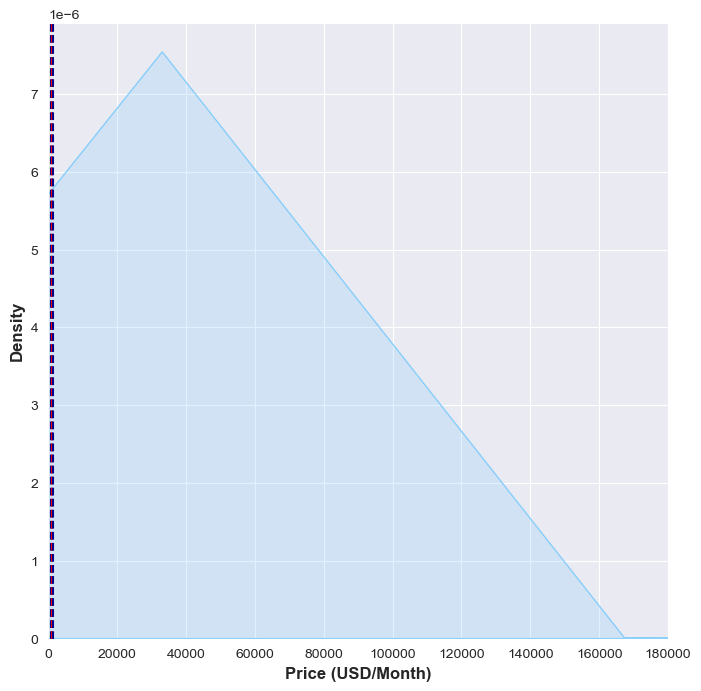

[System] Data Pre-processing: there are 17757 itmes left after cleaning with IQR level 1.5.


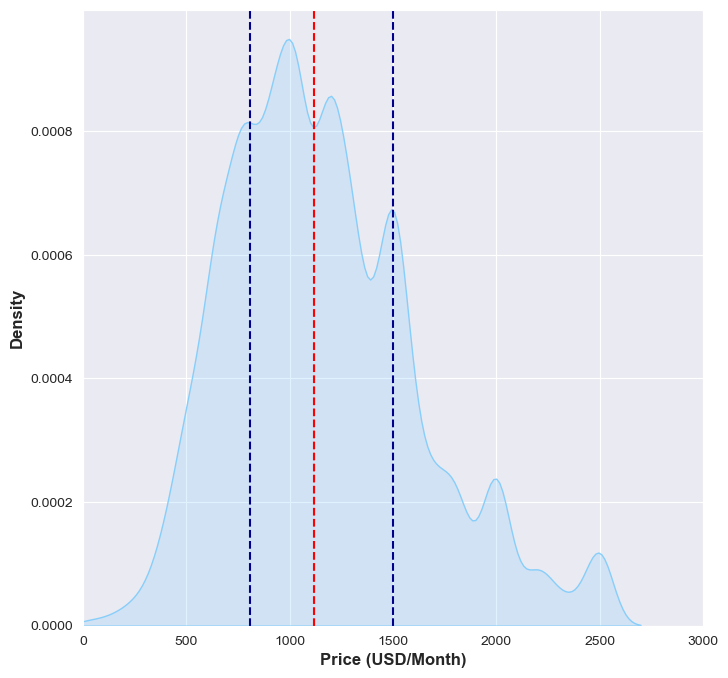

In [11]:
"""          ==========     START OF PRE_PROCESSING   ==========          """

#  remarks: classify target and non-target columns
price_column = "Price (Usd/Month)"
columns_except_price = f_train_data.columns.drop(price_column)
categorical_columns = f_train_data.select_dtypes(include=["object"]).columns
scaled_train_data = f_train_data.copy()


"""  PREPOCESSING: SCALING DATA WITH IQR AND Z-SCORE  """


#  Data Pre-processing evaluation
#  remarks: before cleaning
#  declaration
Q1 = scaled_train_data[price_column].quantile(0.25)
Q2 = scaled_train_data[price_column].quantile(0.50)
Q3 = scaled_train_data[price_column].quantile(0.75)
#  draw kdeplot
print(f"[System] Data Pre-processing: there are {len(scaled_train_data)} itmes before preprocessing cleaning.")
plt.figure(figsize=(8,8))
sns.set_style("darkgrid")
sns.kdeplot(scaled_train_data[price_column], fill = True, color = "lightskyblue") 
plt.axvline(Q1, color='darkblue', linestyle='--', label=f'lower-limit: {Q1:.2f}')
plt.axvline(Q2, color='red', linestyle='--', label=f'median: {Q2:.2f}')
plt.axvline(Q3, color='darkblue', linestyle='--', label=f'upper-limit: {Q3:.2f}')
plt.xlim(0, 180000)
plt.xlabel("Price (USD/Month)", fontsize = 12, fontweight = "bold")
plt.ylabel("Density", fontsize = 12, fontweight = "bold")


#  output kdeplot
try:
    plt.savefig("[Q1] 1_general_kdeplot_distribution_preprocession.jpg", dpi=300, bbox_inches="tight")
except exception as ex:
    errorMessaging("machine learning", "result-output", "failed to produce barchart to copy...")  

#  show kdeplot
plt.show()


#  Data Pre-processing: IQR method
#  remarks: continue removing outliers that basic cleaning unable to remove
#  detect and remove outliers
#  reference: https://www.youtube.com/watch?v=Cw2IvmWRcXs
#  remarks: find the limits
#  (re) declaration
Q1 = scaled_train_data[price_column].quantile(0.25)
Q2 = scaled_train_data[price_column].quantile(0.50)
Q3 = scaled_train_data[price_column].quantile(0.75)
IQR = Q3 - Q1
upper_limit = Q3 + (1.5 * IQR)
lower_limit = Q1 - (1.5 * IQR)
#  draw kdeplot
scaled_train_data = scaled_train_data[(scaled_train_data[price_column] <= upper_limit) & (scaled_train_data[price_column] >= lower_limit)]
print(f"[System] Data Pre-processing: there are {len(scaled_train_data)} itmes left after cleaning with IQR level 1.5.")
plt.figure(figsize=(8,8))
sns.set_style("darkgrid")
sns.kdeplot(scaled_train_data[price_column], fill = True, color = "lightskyblue") 
plt.xlim(0, 3000)
plt.axvline(Q1, color='darkblue', linestyle='--', label=f'lower-limit: {Q1:.2f}')
plt.axvline(Q2, color='red', linestyle='--', label=f'median: {Q2:.2f}')
plt.axvline(Q3, color='darkblue', linestyle='--', label=f'upper-limit: {Q3:.2f}')
plt.xlabel("Price (USD/Month)", fontsize = 12, fontweight = "bold")
plt.ylabel("Density", fontsize = 12, fontweight = "bold")


#  save kdeplot
try:
    plt.savefig("[Q1] 1_general_kdeplot_distribution_iqr.jpg", dpi=300, bbox_inches="tight")
except exception as ex:
    errorMessaging("machine learning", "result-output", "failed to produce barchart to copy...")  

#  show kdeplot
plt.show()





[System] Data Pre-processing: there are 17360 itmes left after cleaning with z-score level 2.50 (testing-based).


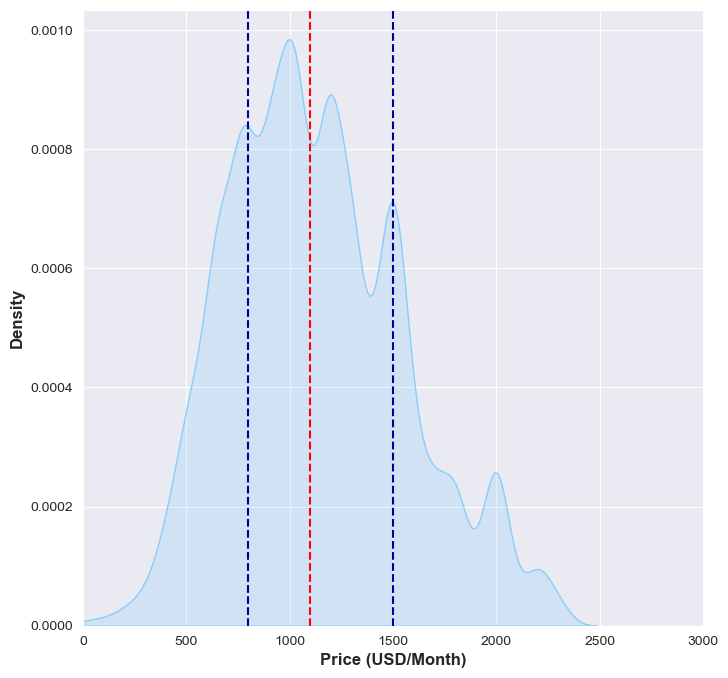

[System] Data Pre-processing: there are 16196 itmes left after cleaning with z-score level 1.75.


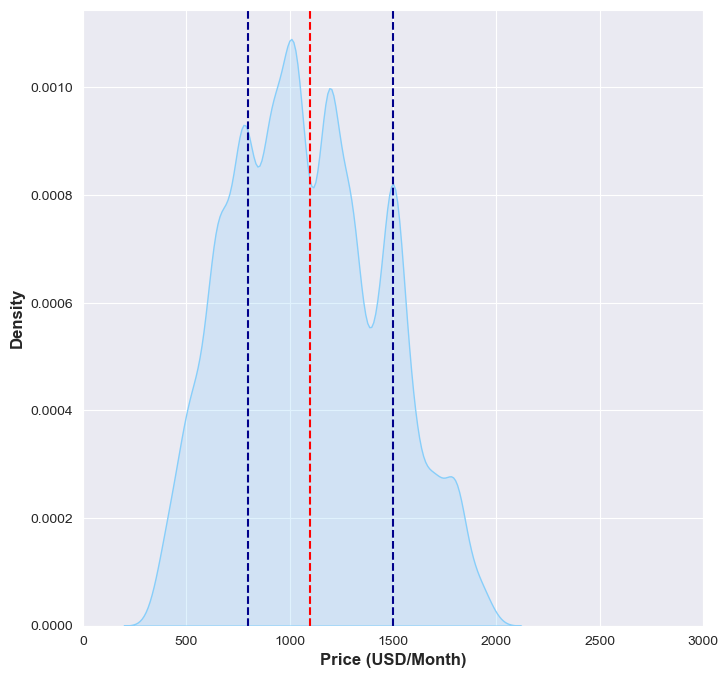

In [12]:

""" Additional Testing: z-score comparison """
testing_zscore_data = scaled_train_data.copy()
Q1 = testing_zscore_data[price_column].quantile(0.25)
Q2 = testing_zscore_data[price_column].quantile(0.50)
Q3 = testing_zscore_data[price_column].quantile(0.75)
testing_zscore_data["zscore"] = (testing_zscore_data[price_column] - testing_zscore_data[price_column].mean()) / testing_zscore_data[price_column].std()
testing_zscore_data = testing_zscore_data[testing_zscore_data["zscore"].abs() <= 2.5]
#  draw kdeplot
print(f"[System] Data Pre-processing: there are {len(testing_zscore_data)} itmes left after cleaning with z-score level 2.50 (testing-based).")
plt.figure(figsize=(8,8))
sns.set_style("darkgrid")
sns.kdeplot(testing_zscore_data[price_column], fill = True, color = "lightskyblue") 
plt.xlim(0, 3000)
plt.axvline(Q1, color='darkblue', linestyle='--', label=f'lower-limit: {Q1:.2f}')
plt.axvline(Q2, color='red', linestyle='--', label=f'median: {Q2:.2f}')
plt.axvline(Q3, color='darkblue', linestyle='--', label=f'upper-limit: {Q3:.2f}')
plt.xlabel("Price (USD/Month)", fontsize = 12, fontweight = "bold")
plt.ylabel("Density", fontsize = 12, fontweight = "bold")

#  save kdeplot
try:
    plt.savefig("[Q1] 1_general_kdeplot_distribution_zscore_testing.jpg", dpi=300, bbox_inches="tight")
except exception as ex:
    errorMessaging("machine learning", "result-output", "failed to produce barchart to copy...")  
#  show kdeplot
plt.show()


#  Data Pre-processing: z-score
#  remarks: continue removing outliers that IQR unable to remove
#  (re) declaration
Q1 = scaled_train_data[price_column].quantile(0.25)
Q2 = scaled_train_data[price_column].quantile(0.50)
Q3 = scaled_train_data[price_column].quantile(0.75)
scaled_train_data["zscore"] = (scaled_train_data[price_column] - scaled_train_data[price_column].mean()) / scaled_train_data[price_column].std()
scaled_train_data = scaled_train_data[scaled_train_data["zscore"].abs() <= 1.75]
#  draw kdeplot
print(f"[System] Data Pre-processing: there are {len(scaled_train_data)} itmes left after cleaning with z-score level 1.75.")
plt.figure(figsize=(8,8))
sns.set_style("darkgrid")
sns.kdeplot(scaled_train_data[price_column], fill = True, color = "lightskyblue") 
plt.xlim(0, 3000)
plt.axvline(Q1, color='darkblue', linestyle='--', label=f'lower-limit: {Q1:.2f}')
plt.axvline(Q2, color='red', linestyle='--', label=f'median: {Q2:.2f}')
plt.axvline(Q3, color='darkblue', linestyle='--', label=f'upper-limit: {Q3:.2f}')
plt.xlabel("Price (USD/Month)", fontsize = 12, fontweight = "bold")
plt.ylabel("Density", fontsize = 12, fontweight = "bold")

#  save kdeplot
try:
    plt.savefig("[Q1] 1_general_kdeplot_distribution_zscore.jpg", dpi=300, bbox_inches="tight")
except exception as ex:
    errorMessaging("machine learning", "result-output", "failed to produce barchart to copy...")  
#  show kdeplot
plt.show()


In [13]:
"""          ==========     START OF MODEL PRECISION CHECKING    ==========          """


"""  PREPOCESSING: ASSIGNING TRAIN AND TEST DATASET  """


#  1. arrange datasets

#  1.1  dividing training and testing datasets
#  remarks: ready datasets for training and testing
train_data_X = pd.get_dummies(f_train_data[columns_except_price], drop_first=True)
copy_train_data_X = train_data_X.copy()
test_data_X = pd.get_dummies(f_test_data[columns_except_price], drop_first=True)
train_data_X, test_data_X = train_data_X.align(test_data_X, join="left", axis=1, fill_value=0)
#  remarks: set classifier division
median_price = f_train_data[price_column].median()
# q3_price = f_train_data[price_column].quantile(0.75)
train_data_y = (f_train_data[price_column] > median_price).astype(int)
test_data_y = (f_test_data[price_column] > median_price).astype(int)



"""  PREPOCESSING: SCALING DATA WITH BUILT-IN SCALER  """

#  1.2  scaling / normalising dataset
""" 
machine learning model with top persition
-  robust scaler:   79.88%, svc; 79.22% random-forrest
-  standard scaler: 78.75%, random-forrest
-  both scalers:   79.16%, random-forrest
"""

#  remarks: robust scaler IQR (minimise extreme factors)
#           accuracy significantly improve, as small part of extreme price in data
scaler_rs = RobustScaler()
train_data_X = scaler_rs.fit_transform(train_data_X)
test_data_X = scaler_rs.transform(test_data_X)

# Ensure that the column names are preserved
# remarks: standard scaler (adjsut standard deviation)
# scaler_ss = StandardScaler()
# train_data_X = scaler_ss.fit_transform(train_data_X)
# test_data_X = scaler_ss.transform(test_data_X)


#  2. training and testing machine-learning model

#  2.1.  testing criteria for GridSearch
""" remarks: partly adopted the GridSearch's parameters due to significantly lower precision     """

# # 2.1.1  random forest parameters searching
# random_forest_classifier = RandomForestClassifier(random_state=42)
# rf_param = {
#     "n_estimators": [200, 250],
#     "max_depth": [7, 9],
#     "min_samples_split": [5, 8],
#     "min_samples_leaf": [5, 8],
#     "class_weight": ["balanced"]
# }
# grid_search = GridSearchCV(estimator = random_forest_classifier, param_grid = rf_param, cv=3, n_jobs=-1)
# rf_grid_search.fit(train_data_X, train_data_y)
# print("\n[System] The best parameters for random forest model:")
# print(grid_search.best_params_)
# 
# #  2.1.2 svc model parameters searching
# svc_classifier = SVC(random_state = 42)
# svc_param = {
#     "C": [0.1, 5, 10],                    
#     "kernel": ["linear", "rbf"],        
#     "gamma": ["scale", "auto"],   
#     "class_weight": ["balanced", None]
# }
# svc_grid_search = GridSearchCV(estimator=svc_classifier, param_grid=svc_param, cv=3, n_jobs=-1)
# svc_grid_search.fit(train_data_X, train_data_y)
# print("\n[System] The best parameters for svc model:")
# print(svc_grid_search.best_params_)
# 
# # 2.1.3  knn model parameters searching
# knn_classifier = KNeighborsClassifier()
# knn_param = {
#     "n_neighbors": [2, 4, 6],   
#     "weights": ["uniform", "distance"],
#     "metric": ["euclidean", "manhattan"] 
# }
# knn_grid_search = GridSearchCV(
#     estimator = knn_classifier,
#     param_grid = knn_param,
#     cv = 3,
#     n_jobs = -1
# )
# knn_grid_search.fit(train_data_X, train_data_y)
# 
# print("\n[System] The best parameters for knn model:")
# print(knn_grid_search.best_params_)
# 
# # 2.1.4  decision tree parameters searching
# dt_param = {
#     "criterion": ["gini", "entropy"], 
#     "max_depth": [4, 8, 12],         
#     "min_samples_split": [4, 6, 8],   
#     "min_samples_leaf": [2, 4, 6],      
#     "class_weight": ["balanced"] 
# }
# dt_grid_search = GridSearchCV(
#     estimator=decision_tree_classifier,
#     param_grid=dt_param,
#     cv=3,
#     n_jobs=-1
# )
# dt_grid_search.fit(train_data_X, train_data_y)
# print("\n[System] The best parameters for Decision Tree model:")
# print(dt_grid_search.best_params_)


"""  ADJUSTMENT:  BUILDING MACHINE LEARNING MODELS  """

# # 2.2  model adoption with selected parameters  
# """ -  all course mentioned classifier + discussion board mentioned + popular classifier
#     -  retquried to be supported by sklearn package                                       """

# #  remarks: decision tree classifier (week 3.5.2)
decision_tree_classifier = DecisionTreeClassifier(
    class_weight = "balanced", 
    criterion = "gini", 
    max_depth = 8, 
    min_samples_leaf = 6, 
    min_samples_split = 4
)
decision_tree_classifier.fit(train_data_X, train_data_y)
dt_prediction_y = decision_tree_classifier.predict(test_data_X)

# #  remarks: random forest classifier (in discussion board)
# #  - searching best params  (hased, only for testing parameters)
random_forest_classifier = RandomForestClassifier(random_state = 42)
random_forest_classifier = RandomForestClassifier(
    n_estimators = 300, 
    # class_weight = "balanced",
    min_samples_split = 6,
)
random_forest_classifier.fit(train_data_X, train_data_y)
rfc_prediction_y = random_forest_classifier.predict(test_data_X)

# #  remarks: knn classifier
knn_classifier = KNeighborsClassifier(
    metric = "manhattan", 
    n_neighbors = 6, 
    weights = "distance"
)
knn_classifier.fit(train_data_X, train_data_y)
knn_prediction_y = knn_classifier.predict(test_data_X)

# #  remarks: svc classifier (in discussion board)
# #  best parameters not adopted as precision slightly dropped.
svc_classifier = SVC(random_state = 42)
svc_classifier.fit(train_data_X, train_data_y)
svc_prediction_y = svc_classifier.predict(test_data_X)

#  remarks: navie bayes (week 4.3.1)
#  report: abandoned, navie bayes do not accepted negatives generated by scaler


#    ==========    [  END OF BUILDING MACHINE LEARNING MODEL ]    ==========


In [14]:
#    ==========    [  START OF CHECKING ACCURACY  -  OPTIONAL ]    ==========

"""  DIAGRAM:  TABLE: PRECISION OF MACHINE LEARNING MODEL """


#  3. compare models and obtain report

def generate_report_row(dataset_test_y, model_predict_y):
    temp = {
    "Accuracy (%)": round(accuracy_score(dataset_test_y, model_predict_y) * 100, 2),
    #  remarks: zero_division for avoid warning, need to keep
    "Precision (%)": round(precision_score(dataset_test_y, model_predict_y, average="weighted", zero_division=0) * 100, 2),
    "Recall (%)": round(recall_score(dataset_test_y, model_predict_y, average="weighted", zero_division=0) * 100, 2),
    "F1 index (%)": round(f1_score(dataset_test_y, model_predict_y, average="weighted", zero_division=0) * 100, 2)
    }
    return temp


def generate_model_precision_report(test_data_y, dt_prediction_y, rfc_prediction_y, knn_prediction_y, svc_prediction_y):
    storage = {}
    #  remarks: fill each models data
    storage["Decision-tree Classifier"] = generate_report_row(test_data_y, dt_prediction_y)
    storage["Random-forest Classifier"] = generate_report_row(test_data_y, rfc_prediction_y)
    storage["KNN Classifier"] = generate_report_row(test_data_y, knn_prediction_y)
    storage["SVC Classifier"] = generate_report_row(test_data_y, svc_prediction_y)
    storage = pd.DataFrame(storage).T
    #  ouput
    storage = storage.sort_values(by="Accuracy (%)", ascending = False)
    return storage


#  visualise output

print("\n[System] machine learning model comparison report has been readied.\n")
print("\n[System] Model's precision report is readied...\n")
model_precision_report = generate_model_precision_report(test_data_y, dt_prediction_y, rfc_prediction_y, knn_prediction_y, svc_prediction_y)
display(model_precision_report)


#  result output

try:
    model_precision_report.to_csv("[table] machine_learning_model_comparison.csv", index=False)
    print("\n[System] machine learning model comparison has been generated...\n")
except:
    errorMessaging("machine learning", "result-output", "failed to produce barchart to csv file...")





[System] machine learning model comparison report has been readied.


[System] Model's precision report is readied...



,Accuracy (%),Precision (%),Recall (%),F1 index (%)
SVC Classifier,78.72,78.63,78.72,78.64
Random-forest Classifier,78.36,78.28,78.36,78.31
KNN Classifier,75.89,75.74,75.89,75.73
Decision-tree Classifier,74.43,74.70,74.43,74.52



[System] machine learning model comparison has been generated...



In [15]:


"""  ==========     REGREESION MACHINE LEARNING MODEL     ==========  """
"""
remarks: noted that the data is fragmented without apprarent linear pattern.
         this part is only demonstrate regression is not ideal for our tasks
"""

#  section:  parameter testing

# #  SVR regressor parameters testing
# svr_regressor = SVR(kernel="rbf", C=1.5)
# svr_params = {"C": [0.1, 1.5, 5], "kernel": ["rbf", "linear"], "gamma": ["scale", "auto"]}
# svr_grid_search = GridSearchCV(estimator=svr_regressor,param_grid=svr_params, cv=3, n_jobs=-1,scoring='neg_mean_squared_error')
# svr_grid_search.fit(train_data_X, train_data_y)
# print(svr_grid_search.best_params_)  


# #  random forest regressor parameters testing
# rfr_regressor = RandomForestRegressor(random_state=42)
# rfr_params = {"n_estimators": [200, 250],"max_depth": [7, 9, None],"min_samples_split": [5, 8],"min_samples_leaf": [5, 8]}
# rfr_grid_search = GridSearchCV(estimator = rfr_regressor, param_grid = rfr_params, cv = 3,n_jobs = -1,scoring = 'neg_mean_squared_error')
# rfr_grid_search.fit(train_data_X, train_data_y)
# print( rfr_grid_search.best_params_)


#  KNN regressor parameters testing
# kr_regressor = KNeighborsRegressor()
# kr_params = {"n_neighbors": [2, 4, 6], "weights": ["uniform", "distance"], "metric": ["euclidean", "manhattan"]}
# kr_grid_search = GridSearchCV(estimator = kr_regressor, param_grid = kr_params, cv = 3,  n_jobs = -1,scoring = 'neg_mean_squared_error')
# kr_grid_search.fit(train_data_X, train_data_y)
# print(kr_grid_search.best_params_)

# #  GB regressor parameters testing
# gbr_regressor = GradientBoostingRegressor(random_state=42)
# gbr_params = {"n_estimators": [100, 200], "max_depth": [3, 5], "learning_rate": [0.05, 0.1, 0.2]}
# gbr_grid_search = GridSearchCV(estimator = gbr_regressor, param_grid = gbr_params, cv = 3, n_jobs = -1, scoring='neg_mean_squared_error')
# gbr_grid_search.fit(train_data_X, train_data_y)
# print(gbr_grid_search.best_params_)


#  get result
#  1. SVR Regressor
svr_regressor = SVR(kernel="rbf", C = 1.5, gamma = "scale")
svr_regressor.fit(train_data_X, train_data_y)
svr_prediction_y = svr_regressor.predict(test_data_X)

#  2. Random Forest Regressor
random_forest_regressor = RandomForestRegressor(n_estimators = 250, max_depth = 9, min_samples_leaf = 8, random_state = 42)
random_forest_regressor.fit(train_data_X, train_data_y)
rfr_prediction_y = random_forest_regressor.predict(test_data_X)

#  3. KNN Regressor
knn_regressor = KNeighborsRegressor(n_neighbors = 8, weights = "distance", metric = "manhattan")
knn_regressor.fit(train_data_X, train_data_y)
kr_prediction_y = knn_regressor.predict(test_data_X)

#  4. Gradient Regressor
gb_regressor = GradientBoostingRegressor(n_estimators = 250, max_depth = 5,learning_rate = 0.05, random_state = 42)
gb_regressor.fit(train_data_X, train_data_y)
gbr_prediction_y = gb_regressor.predict(test_data_X)


#    ==========    [  START OF CHECKING ACCURACY  -  OPTIONAL ]    ==========

"""  DIAGRAM:  TABLE: PRECISION OF MACHINE LEARNING MODEL """

def generate_regressor_report_row(true_y, pred_y):
    temp = {
        "MAE": round(mean_absolute_error(true_y, pred_y), 4),
        "MSE": round(mean_squared_error(true_y, pred_y), 4),
        "RMSE": round(mean_squared_error(true_y, pred_y), 4),
        "R2 Score": round(r2_score(true_y, pred_y), 4)
    }
    return temp

def generate_regressor_precision_report(true_y, svr_pred, rfr_pred, knn_pred, gbr_pred):
    storage = {}
    storage["SVR Regressor"] = generate_regressor_report_row(true_y, svr_pred)
    storage["Random Forest Regressor"] = generate_regressor_report_row(true_y, rfr_pred)
    storage["KNN Regressor"] = generate_regressor_report_row(true_y, knn_pred)
    storage["Gradient Boosting Regressor"] = generate_regressor_report_row(true_y, gbr_pred)
    report = pd.DataFrame(storage).T
    report = report.sort_values(by = "RMSE", ascending = True)
    return report


#  show tablular result

regressor_precision_report = generate_regressor_precision_report(test_data_y, svr_prediction_y, rfr_prediction_y, knn_prediction_y, gbr_prediction_y)
print("\n[System] Regression models comparison report:\n")
display(regressor_precision_report)



# save tabular result
try:
    regressor_precision_report.to_csv("[Q1.3] csv_1c_general_regressor-precision.csv", index=True)
except:
    errorMessaging("question 1.3", "result-output", "failed to produce file...") 





[System] Regression models comparison report:



,MAE,MSE,RMSE,R2 Score
Gradient Boosting Regressor,0.2989,0.1430,0.1430,0.4124
SVR Regressor,0.2715,0.1444,0.1444,0.4067
Random Forest Regressor,0.3166,0.1595,0.1595,0.3446
KNN Regressor,0.2411,0.2411,0.2411,0.0094



[System] barchart of model comparison report has been readied.



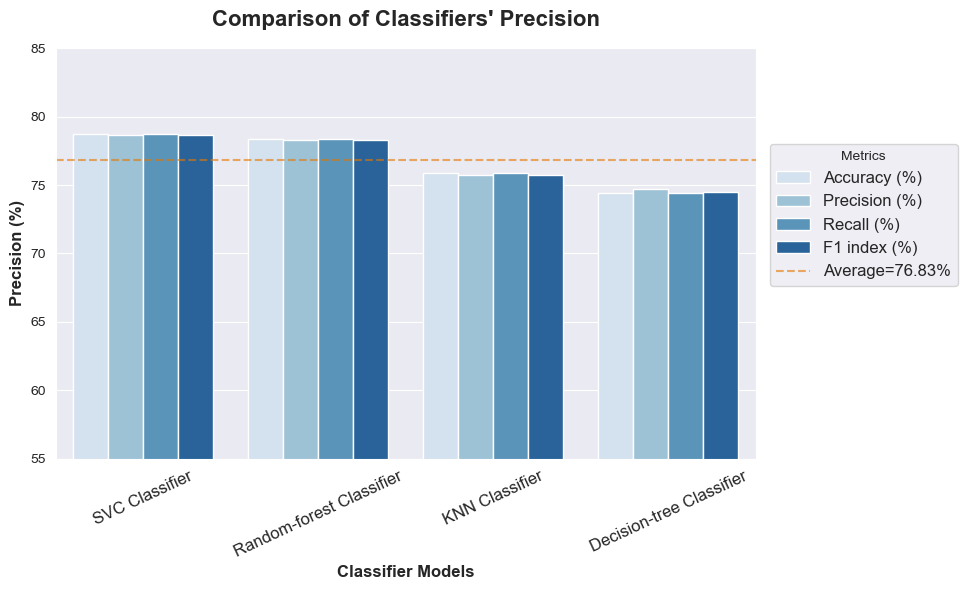

In [16]:

"""  DIAGRAM:  BARCHART - PRECISION OF MACHINE LEARNING MODEL  """

#  1. prepare dataframe
if "level_0" in model_precision_report.columns:
    model_precision_report = model_precision_report.drop(columns=["level_0"])

#  remarks: reset index

model_precision_report = model_precision_report.reset_index()
#  remarks: re-formualte dataframe
reformatted_dataframe = model_precision_report.melt(
    id_vars="index",
    value_vars=["Accuracy (%)", "Precision (%)", "Recall (%)", "F1 index (%)"],
    var_name="Metrics",
    value_name="Percision (percent)"
)

#  2. visualise with charts, group bar chart

plt.figure(figsize=(10, 6))
sns.set_style("darkgrid")
barplot = sns.barplot(data = reformatted_dataframe,x = "index", y = "Percision (percent)", hue = "Metrics",palette = "Blues")
average_line = reformatted_dataframe["Percision (percent)"].mean()
plt.axhline(y = average_line, color = "#e67700", linestyle="--", alpha = 0.6,  linewidth = 1.5, label = f"Average={average_line:.2f}%")
plt.xticks(rotation = 25, fontsize = 12)
plt.title("Comparison of Classifiers' Precision", fontsize = 16, fontweight = "bold", pad = 16)
plt.xlabel("Classifier Models",  fontsize = 12, fontweight = "bold")
plt.ylabel("Precision (%)",  fontsize = 12, fontweight = "bold")
plt.legend(
    title = "Metrics",
    loc = "lower right",
    bbox_to_anchor=(1.3, 0.4),
    fontsize = 12
)

#  remarks: highlight the difference with y-axis
bottom, top = plt.ylim() 
plt.ylim((55, 85))
plt.tight_layout()


#  output result
try:
    plt.savefig("[Q1] 1_general_bhart_precision.jpg", dpi=300, bbox_inches="tight")
except exception as ex:
    errorMessaging("machine learning", "result-output", "failed to produce barchart to copy...")  


#  visualise result
print("\n[System] barchart of model comparison report has been readied.\n")
plt.show()





[System] Q1 piechart of factors correclation has been readied.



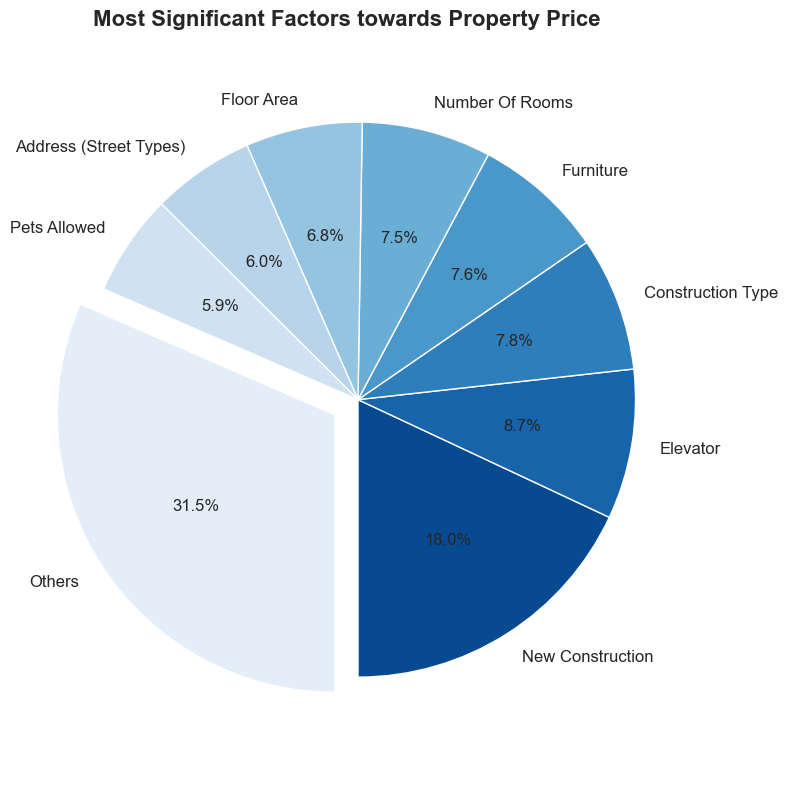

In [17]:
"""          ==========     START OF QUESTION 1A     ==========          """

"""  DIAGRAM:  PIECHART - GENERAL CORRELATION  """

#  declaration
display_cat_numbers = 8

copy_train_data = scaled_train_data.copy()
train_data_X_columns = copy_train_data.columns
rf_importances = random_forest_classifier.feature_importances_
dict_correlation = {}


#  remarks: extract major category by ignoring those sub-categories generated by dummies
for index in range(len(train_data_X_columns)):
    column = train_data_X_columns[index]
    main_factor = column.split("_")[0]
    importance = rf_importances[index]
    if main_factor in dict_correlation:
        dict_correlation[main_factor] += importance
    else:
        dict_correlation[main_factor] = importance


#  remarks: re-counting correlation based on selected categories, and enlarge significance
correlation_dataframe = pd.DataFrame({
    "Factors": list(dict_correlation.keys()),
    "Correlation (%)": list(dict_correlation.values())
})

correlation_dataframe["Correlation (%)"] = round(correlation_dataframe["Correlation (%)"], 4) * 100
correlation_dataframe = correlation_dataframe.sort_values(by = "Correlation (%)", ascending = False)

#  remarks: restructure dataframe, merge insignificant as others
corr_data_first = correlation_dataframe.head(display_cat_numbers)
corr_data_second = correlation_dataframe.iloc[display_cat_numbers:]
if len(corr_data_second) > 0:
    others_half = pd.DataFrame({"Factors": ["Others"], "Correlation (%)": [corr_data_second["Correlation (%)"].sum()]})
    merged_data = pd.concat([corr_data_first, others_half], ignore_index = True)
else:
    merged_data = corr_data_first

#  remarks: drawing part
plt.figure(figsize =(8, 8))
sns.set_style("darkgrid")
plt.pie(
    merged_data["Correlation (%)"],
    labels = merged_data["Factors"],
    autopct = "%1.1f%%",
    startangle = 270,
    explode = [0,0,0,0,0,0,0,0,0.1],
    colors = sns.color_palette("Blues", n_colors=len(merged_data))[::-1],
    textprops = {"fontsize": 12}
)
plt.title("Most Significant Factors towards Property Price", fontsize = 16, fontweight = "bold")
plt.axis("equal")
plt.tight_layout()


#  output
try:
    plt.savefig("[Q1] 1_general_piechart_correlation.jpg")
except exception as ex:
    errorMessaging("question 1", "result-output", "failed to produce piechart to copy...")  


#  visualising
print("\n[System] Q1 piechart of factors correclation has been readied.\n")
plt.show()


# to be used
list_feature_columns = merged_data.columns


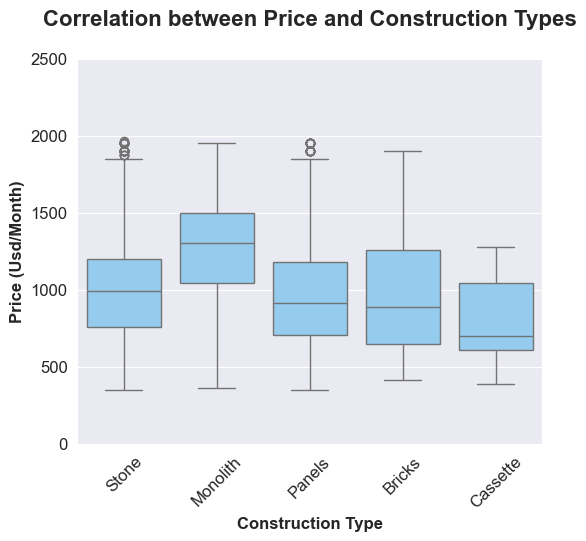

In [18]:
"""  DIAGRAM:  BOXPLOT - CORR BETWEEN PRICE AND NEW CONSTRUCTION  """

"""  DIAGRAM:  BOXPLOT - CORR BETWEEN PRICE AND RENOVATION  """

#  declarations
selected_column_1a3 = "Construction Type"
selected_title_1a3 = "Correlation between Price and Construction Types"
#  remarks: sorting count, make sure the violin bars visualise in order perfectly
copy_train_data = scaled_train_data.copy()

#  draw boxplot
plt.figure(figsize=(6, 5))
chart_1a3_spec = sns.boxplot(x = selected_column_1a3, y = price_column, data = copy_train_data, color = "lightskyblue")
plt.title(selected_title_1a3, fontsize = 16, fontweight = "bold", pad = 24)
plt.xlabel(selected_column_1a3, fontsize = 12, fontweight = "bold")
plt.ylabel(price_column, fontsize = 12, fontweight = "bold")
plt.xticks(rotation = 45, fontsize = 12)
plt.ylim(0, 2500)
plt.yticks(fontsize = 12)

#  save boxplot
try:
    plt.savefig("[Q1.1] 1.1.3_spec_boxplot.jpg")
except:
    errorMessaging("question 1.1", "result-output", "failed to produce file...")

#  show boxplot
plt.show()



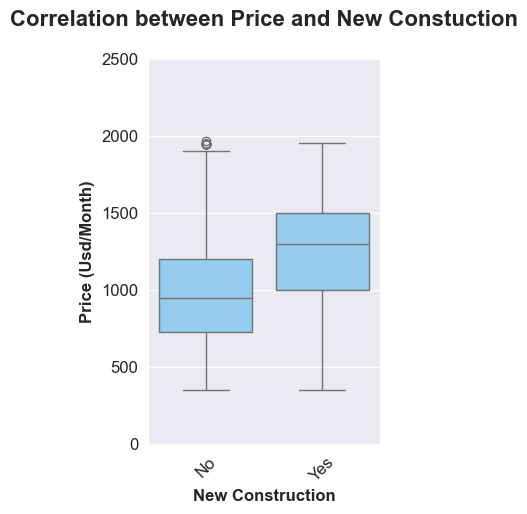

In [19]:
#  declarations
selected_column_1a1 = "New Construction"
selected_title_1a1 = "Correlation between Price and New Constuction"
#  remarks: reamin, as few extreme data impact the chart visualising
copy_train_data = scaled_train_data.copy()

#  draw boxplot
plt.figure(figsize=(3, 5))
chart_1a1_spec = sns.boxplot(x = selected_column_1a1, y = price_column, data = copy_train_data,color = "lightskyblue")
plt.title(selected_title_1a1, fontsize = 16, fontweight = "bold", pad = 24)
plt.xlabel(selected_column_1a1, fontsize = 12, fontweight = "bold")
plt.ylabel(price_column, fontsize = 12, fontweight = "bold")
plt.xticks(rotation = 45, fontsize = 12)
plt.ylim(0, 2500)
plt.yticks(fontsize = 12)

#  save boxplot
try:
    plt.savefig("[Q1.1] 1.1.1_spec_boxplot.jpg")
except:
    errorMessaging("question 1.1", "result-output", "failed to produce file...")

#  show boxplot
plt.show()

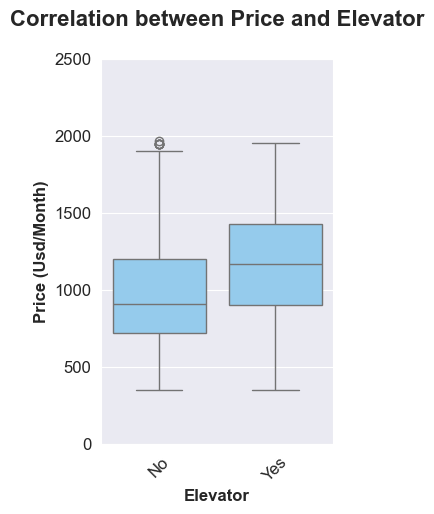

In [20]:
"""  DIAGRAM:  BOXPLOT - CORR BETWEEN PRICE AND ELEVATOR  """

#  declarations
selected_column_1a2 = "Elevator"
selected_title_1a2 = "Correlation between Price and Elevator"
#  remarks: reamin, as few extreme data impact the chart visualising
copy_train_data = scaled_train_data.copy()

#  draw boxplot
plt.figure(figsize=(3, 5))
chart_1a2_spec = sns.boxplot(x = selected_column_1a2, y = price_column, data = copy_train_data, color = "lightskyblue")
plt.title(selected_title_1a2, fontsize = 16, fontweight = "bold", pad = 24)
plt.xlabel(selected_column_1a2, fontsize = 12, fontweight = "bold")
plt.ylabel(price_column, fontsize = 12, fontweight = "bold")
plt.xticks(rotation = 45, fontsize = 12)
plt.ylim(0, 2500)
plt.yticks(fontsize = 12)


#  save boxplot
try:
    plt.savefig("[Q1.1] 1.1.2_spec_boxplot.jpg")
except:
    errorMessaging("question 1.1", "result-output", "failed to produce file...")

#  show boxplot
plt.show()

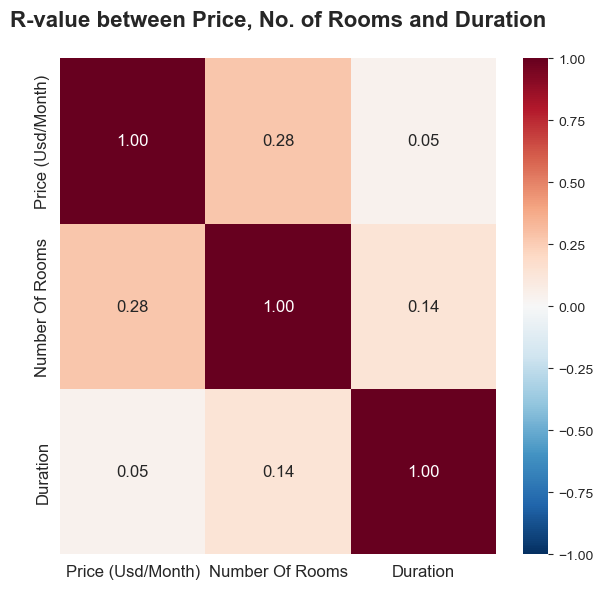

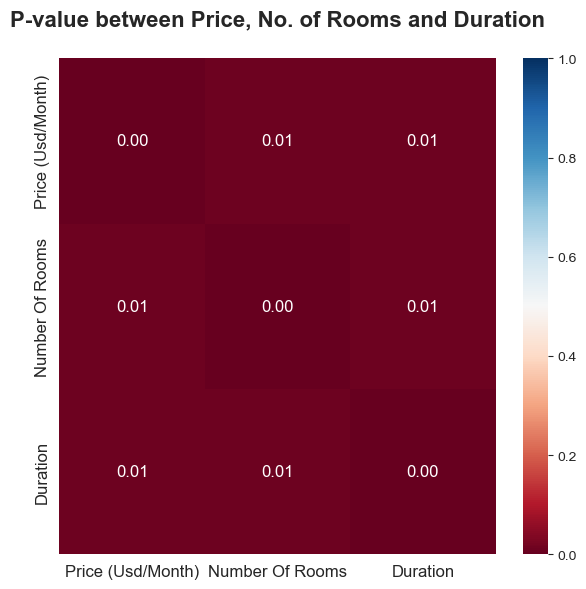

In [21]:

"""          ==========     START OF QUESTION 1B     ==========          """

"""  DIAGRAM:  HEATMAP - CORR BETWEEN 3 DESIGNATED COLUMNS  """

#   declaration
designated_list = ["Price (Usd/Month)", "Number Of Rooms", "Duration"]
copy_train_data = scaled_train_data.copy()
copy_train_data = copy_train_data[designated_list].astype("object")


#  remarks: originally formatted in data wraggling, must be daily, monthly and annually
for index in copy_train_data.index:
    cell_value = copy_train_data.loc[index, "Duration"]
    if isinstance(cell_value, str) and cell_value.lower() == "daily":
        copy_train_data.loc[index, "Duration"] = 1
    elif isinstance(cell_value, str) and cell_value.lower() == "weekly":
        copy_train_data.loc[index, "Duration"] = 7
    elif isinstance(cell_value, str) and cell_value.lower() == "monthly":
        copy_train_data.loc[index, "Duration"] = 30
    elif isinstance(cell_value, str):
        copy_train_data.loc[index, "Duration"] = 365
# type warning solution
copy_train_data["Duration"] = pd.to_numeric(copy_train_data["Duration"], errors="coerce")

#  calculate r-value and p-value
#  https://stackoverflow.com/questions/25571882/pandas-columns-correlation-with-statistical-significance
r_values_q1b = pd.DataFrame(index=copy_train_data.columns, columns=copy_train_data.columns, dtype=float)
p_values_q1b = pd.DataFrame(index=copy_train_data.columns, columns=copy_train_data.columns, dtype=float)

#  transplant to pd.dataframe for heatmap 
for column in copy_train_data.columns:
    for row in copy_train_data.columns:
        count = 0
        if column == row:
            r_values_q1b.loc[column, row] = 1
            p_values_q1b.loc[column, row] = 0
            count + 1
        else:
            r_value_q1b, p_value_q1b = stats.spearmanr(copy_train_data[column], copy_train_data[row], nan_policy='omit')
            # remarks: extremely insignificant numbers round as 0, but still should not be 0
            r_values_q1b.loc[column, row] = r_value_q1b
            if p_value_q1b < 0.01:
                p_values_q1b.loc[column, row] = 0.01
                count += 1
            else:
                p_values_q1b.loc[column, row] = p_value_q1b
                count += 1

#  draw heatmap
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
chart_1a_general_pval = sns.heatmap(r_values_q1b, cmap = "RdBu_r", xticklabels = designated_list, yticklabels = designated_list, annot=True, annot_kws={"size": 12}, fmt = ".2f", vmin = -1, vmax = 1)
plt.title("R-value between Price, No. of Rooms and Duration", fontsize = 16, fontweight = "bold", pad = 24)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()

#  save heatmap
try:
    plt.savefig("[[Q1.1] 1.2_gneral_heatmap_r-value.jpg")
except:
    errorMessaging("question 1.2", "result-output", "failed to produce file...")

#  show heatmap
plt.show()


#  draw heatmap
plt.figure(figsize=(6, 6))
sns.set_style("darkgrid")
chart_1a_general_pval = sns.heatmap(p_values_q1b, cmap = "RdBu", xticklabels = designated_list, yticklabels = designated_list, annot=True, annot_kws={"size": 12}, fmt = ".2f", vmin = 0, vmax = 1)
plt.title("P-value between Price, No. of Rooms and Duration", fontsize = 16, fontweight = "bold", pad = 24)
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.tight_layout()

#  save heatmap
try:
    plt.savefig("[[Q1.1] 1.2_gneral_heatmap_r-value.jpg")
except:
    errorMessaging("question 1.2", "result-output", "failed to produce file...")

#  show heatmap
plt.show()



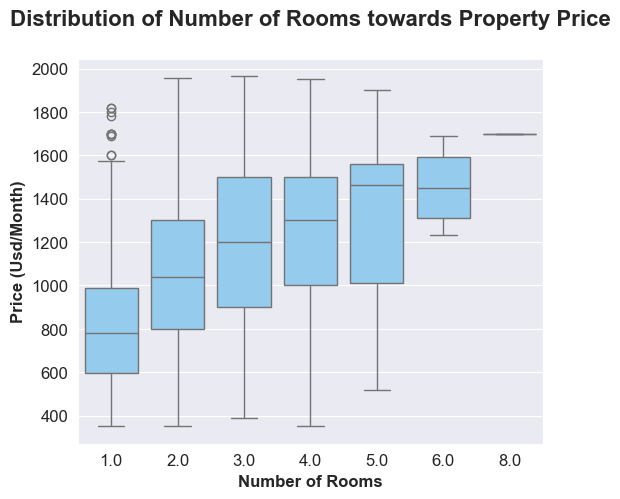

In [22]:
#  Micro-scope for Group 1

#  remarks: type warning
copy_train_data[designated_list[0]] = pd.to_numeric(copy_train_data[designated_list[0]], errors = 'coerce')
copy_train_data[designated_list[1]] = pd.to_numeric(copy_train_data[designated_list[1]], errors = 'coerce')

#  draw diagrams
plt.figure(figsize=(6, 5))
sns.set_style("darkgrid")
chart_1b1_spec = sns.boxplot(data = copy_train_data, x = designated_list[1], y = designated_list[0], color = "lightskyblue")
plt.title("Distribution of Number of Rooms towards Property Price", fontsize = 16, fontweight = "bold", pad = 24)
plt.ylabel("Price (Usd/Month)", fontsize = 12, fontweight = "bold")
plt.xlabel("Number of Rooms", fontsize = 12, fontweight = "bold")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

#  generation
try:
    plt.savefig("[Q1.2] 1.2.1_spec_boxplot.jpg")
except:
    errorMessaging("question 1.2", "result-output", "failed to produce file...")

#  show boxplot
plt.show()



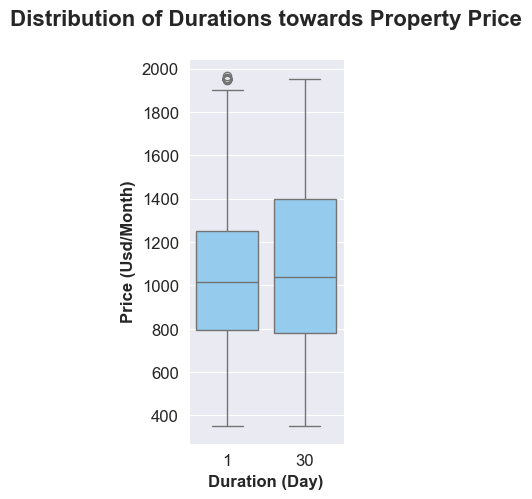

In [23]:
#  Micro-scope for Group 2

copy_train_data["Duration Category"] = copy_train_data[designated_list[2]].astype(str)

#  draw boxplot
plt.figure(figsize=(2, 5))
sns.set_style("darkgrid")
chart_1b2_spec = sns.boxplot(data = copy_train_data, x = designated_list[2], y = designated_list[0],  color = "lightskyblue")
plt.title("Distribution of Durations towards Property Price", fontsize = 16, fontweight = "bold", pad = 24)
plt.xlabel("Duration (Day)", fontsize = 12, fontweight = "bold")
plt.ylabel(price_column, fontsize = 12, fontweight = "bold")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

#  save boxblot
try:
    plt.savefig("[Q1.2] 1.2.2_spec_boxplot.jpg")
except:
    errorMessaging("question 1.2", "result-output", "failed to produce file...")

#  show boxplot
plt.show()


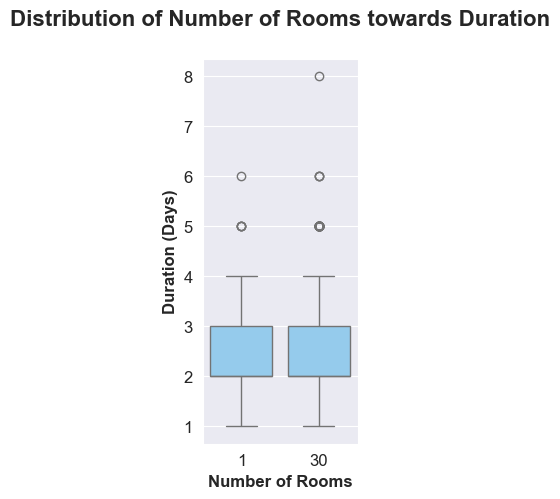

In [24]:
#  Micro-scope for Group 3

#  draw boxplot
plt.figure(figsize=(2, 5))
sns.set_style("darkgrid")
chart_1b3_spec = sns.boxplot(data = copy_train_data, x = designated_list[2], y = designated_list[1], color = "lightskyblue")
plt.title("Distribution of Number of Rooms towards Duration", fontsize = 16, fontweight = "bold", pad = 24)
plt.xlabel("Number of Rooms", fontsize = 12, fontweight = "bold")
plt.ylabel("Duration (Days)", fontsize = 12, fontweight = "bold")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)

#  save boxplot
try:
    plt.savefig("[Q1.2] 1.2.3_spec_boxplot.jpg")
except:
    errorMessaging("question 1.2", "result-output", "failed to produce file...")

#  show boxplot
plt.show()



In [25]:
"""  DIAGRAM:  TABLE: F-STAT OF FEATURE VALUES """

#  declaration
copy_train_data = scaled_train_data.copy()
price_column = "Price (Usd/Month)"
list_feature_columns = ["Address (Street Types)", "Address (City/Town)", "New Construction", "Elevator", "Construction Type", "Number Of Rooms", "Floors In The Building", "Pets Allowed", "Floor Area", "Furniture"]

#  calvualtion
def analyse_anova(data, feature_column, price_column):
    groups = []
    unique_vals = data[feature_column].dropna().unique()
    
    for cell_value in unique_vals:
        group_prices = data[data[feature_column] == cell_value][price_column].values
        if len(group_prices) < 2:
            continue
        groups.append(group_prices)
    
    if len(groups) < 2:
        return None
    
    f_statistics, p_value = stats.f_oneway(*groups)
    if p_value < 0.01 and p_value > 0:
        p_value = 0.01
    
    return {
        "Column": feature_column,
        "f-statistics": round(f_statistics, 4),
        "p-value": round(p_value, 8)
    }


#  convert list to pd dataframe
results = []
for column in list_feature_columns:
    result = analyse_anova(copy_train_data, column, price_column)
    if result:
        results.append(result)
        
#  show dataframe
anova_report = pd.DataFrame(results)
anova_report = anova_report.sort_values(by = "f-statistics", ascending = False)
display(anova_report)

try:
    anova_report.to_csv("[Q1.3]_f-stat_feature_columns.csv", index=False)
except Exception as e:
    errorMessaging("question 1.3", "result-output", "failed to produce file...") 
    


,Column,f-statistics,p-value
2,New Construction,2547.4478,0.00
3,Elevator,943.4285,0.01
4,Construction Type,718.9394,0.00
5,Number Of Rooms,346.8543,0.00
9,Furniture,182.9943,0.01
7,Pets Allowed,111.1903,0.01
6,Floors In The Building,94.0428,0.00
8,Floor Area,23.8362,0.00
0,Address (Street Types),22.2190,0.00
1,Address (City/Town),13.3920,0.01


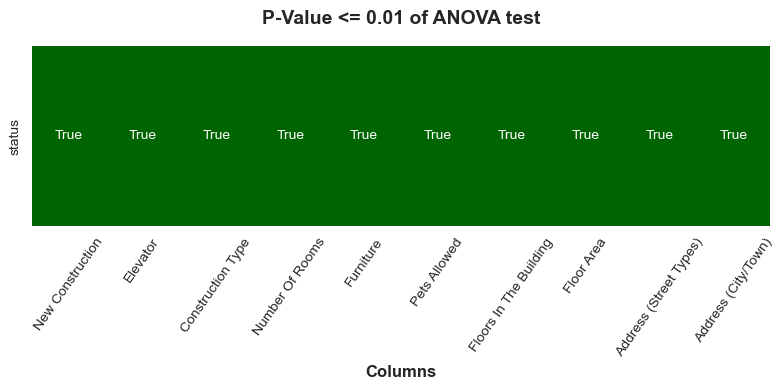

In [26]:

# convert datafram to vools
anova_bools = pd.DataFrame({ "status" : anova_report["p-value"] <= 0.01 })
anova_bools.index = anova_report["Column"]

#  draw heatmap
plt.figure(figsize = (8, 4))
sns.heatmap(data = anova_bools.T, fmt = '', annot = True, cmap = ["darkgreen", "darkred"], cbar = False, xticklabels = True)
plt.title("P-Value <= 0.01 of ANOVA test", fontsize = 14, fontweight = "bold", pad = 16)
plt.xticks(rotation = 55, fontsize = 10)
plt.yticks(fontsize = 10)
plt.xlabel("Columns", fontsize = 12, fontweight = "bold")
plt.tight_layout()

# save heatmap
try:
    plt.savefig("[Q1.3] heatmap_1c_anova_boolean.jpg")
except:
    errorMessaging("question 1.3", "result-output", "failed to produce file...")

#  show heatmap
plt.show()


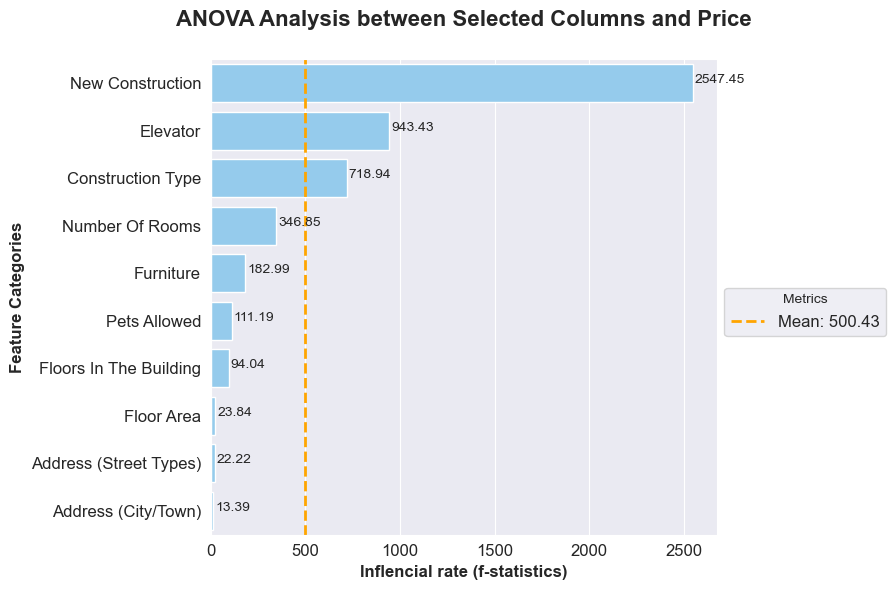

In [27]:
"""  DIAGRAM:  TABLE: P VALUE OF FEATURE VALUES """

f_stat_mean = anova_report["f-statistics"].mean()
        
#  draw barchart
plt.figure(figsize=(10, 6))
sns.barplot(data = anova_report.reset_index(), x = "f-statistics", y = "Column", color = "lightskyblue")
plt.title("ANOVA Analysis between Selected Columns and Price", fontsize = 16, fontweight="bold", pad = 24)
plt.xlabel("Inflencial rate (f-statistics)", fontsize=12, fontweight = "bold")
plt.ylabel("Feature Categories", fontsize = 12, fontweight = "bold")
plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.axvline(x = f_stat_mean, color = "orange", linestyle = '--', linewidth = 2, label = f"Mean: {f_stat_mean:.2f}")
plt.legend(
    title = "Metrics",
    loc = "lower right",
    bbox_to_anchor=(1.35, 0.4),
    fontsize = 12
)
for index, value in enumerate(anova_report["f-statistics"]):
    plt.text(value + 10, index, f"{value:.2f}")
plt.tight_layout()

#  save heatmap
try:
    plt.savefig("[Q1.3] heatmap_1c_anova_f-stat.jpg")
except:
    errorMessaging("question 1.3", "result-output", "failed to produce file...")

#  show barchart
plt.show()



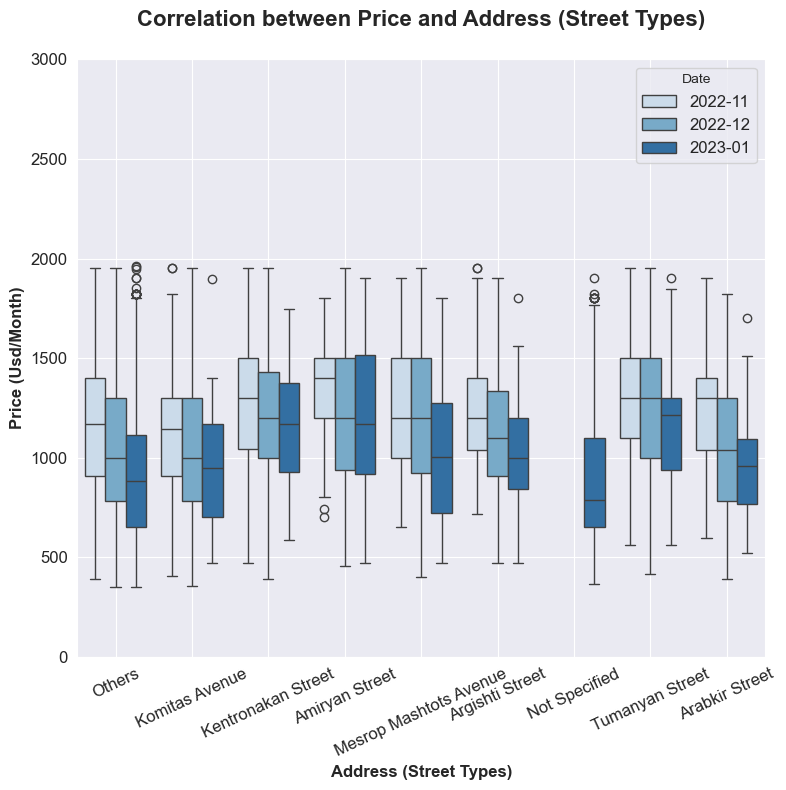

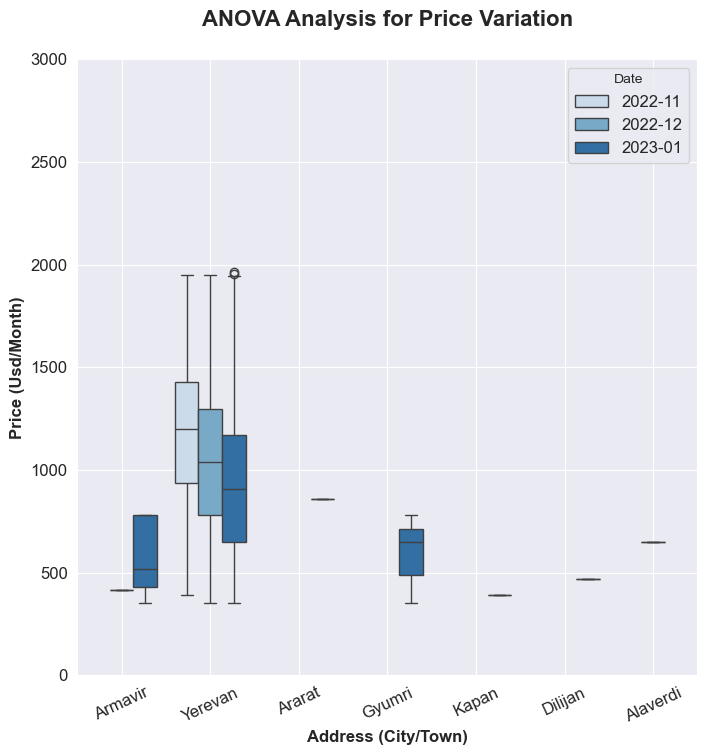

In [28]:

"""          ==========     START OF QUESTION 1C     ==========          """


"""  DIAGRAM:  BOXPLOTS - CORR BETWEEN PRICE AND ADDRESS (STR AND TOWN TYPES) """


#  extract top items from dataset (address column)
copy_train_data = scaled_train_data.copy()
extracted_list = copy_train_data["Address (Street Types)"].value_counts().head(8).index.tolist()
list_address_group = []
for value in copy_train_data["Address (Street Types)"]:
    if value in extracted_list:
        list_address_group.append(value)
    else:
        list_address_group.append("Others")
copy_train_data["Address Group (Street Types)"] =  list_address_group


#  merge and reform date column for sorting chronlogically
temp_year = copy_train_data["Date (Year)"]
temp_month = copy_train_data["Date (Month)"]
temp_day = copy_train_data["Date (Day)"]
temp_datetime = temp_year + "-" + temp_month + "-" + temp_day
copy_train_data["Date"] = pd.to_datetime(temp_datetime, errors="coerce") 
copy_train_data["Date"] = copy_train_data["Date"].dt.to_period("M").astype(str)
#  remarks: for sorting only
list_chron_dates = copy_train_data["Date"].unique()
list_chron_dates_datetime = [str(pd.to_datetime(date).to_period("M")) for date in list_chron_dates]
list_chron_dates_datetime.sort()

address_groups_count = copy_train_data.groupby("Address Group (Street Types)")[price_column].count()
sort_address_groups = address_groups_count.sort_values(ascending=False)
list_address_groups = sort_address_groups.index.tolist()

#  generate usable data for diagrams
#  remarks: data - address (street types)_
extracted_list_str = ["Price (Usd/Month)", "Address Group (Street Types)", "Date"]
extracted_list_town = ["Price (Usd/Month)", "Address (City/Town)", "Date"]
#  remarks: data - address (town/city)
extracted_data_str = copy_train_data[extracted_list_str]
extracted_data_town = copy_train_data[extracted_list_town]


#  draw boxplot
#  remarks: diagram - address (street name)
plt.figure(figsize=(8, 8))
sns.set_style("darkgrid")
address_str_chart = sns.boxplot(x="Address Group (Street Types)", y=price_column, hue="Date", data=extracted_data_str, hue_order= list_chron_dates_datetime, order = list_address_groups, palette= 'Blues')
plt.title("Correlation between Price and Address (Street Types)", fontsize = 16, fontweight = "bold", pad = 24)
plt.xlabel("Address (Street Types)", fontsize=12, fontweight = "bold")
plt.ylabel(price_column, fontsize = 12, fontweight = "bold")
plt.xticks(rotation = 25, fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim(0, 3000)
plt.legend(title = "Date",fontsize = 12)
address_str_chart.grid(True)
plt.tight_layout()

#  save boxplot - 1
try:
    plt.savefig("[Q1.2] boxplot-price-to-address-street.jpg")
except:
    errorMessaging("question 1.2", "result-output", "failed to produce file...")

#  show boxplot - 1
plt.show()


#  draw boxplot - 2
#  remarks: diagram - address (town/city)
plt.figure(figsize=(8, 8))
sns.set_style("darkgrid")
address_str_chart = sns.boxplot(x="Address (City/Town)", y = price_column, hue="Date", data=extracted_data_town, hue_order= list_chron_dates_datetime, palette= 'Blues')
plt.title("ANOVA Analysis for Price Variation", fontsize = 16, fontweight = "bold", pad = 24)
plt.xlabel("Address (City/Town)", fontsize=12, fontweight = "bold")
plt.ylabel(price_column, fontsize = 12, fontweight = "bold")
plt.xticks(rotation = 25, fontsize = 12)
plt.yticks(fontsize = 12)
plt.ylim(0, 3000)
plt.legend(title = "Date",fontsize = 12)
address_str_chart.grid(True)
plt.tight_layout

#  save boxplot - 2
try:
    plt.savefig("[Q1.3] boxplot-price-to-address-towns.jpg")
except:
    errorMessaging("question 1.3", "result-output", "failed to produce file...")

#  show boxplot - 2
plt.show()

